In [175]:
import os
from kbmod.image_info import ImageInfoSet, ImageInfo
from glob import glob
from astropy.io import fits
import numpy as np
from astropy.time import Time
import kbmod.search as kb
from kbmod.run_search import run_search
#from parsers.AtlasParser import AtlasParser

In [176]:
from datetime import datetime, timedelta
from astropy.nddata import Cutout2D
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
import astropy.units as u
import subprocess
import cv2

import warnings
from astropy.io.fits.verify import VerifyWarning
from astropy.wcs import FITSFixedWarning

# Ignore specific warnings
warnings.simplefilter('ignore', VerifyWarning)
warnings.simplefilter('ignore', FITSFixedWarning)

class ATLASParser():
    
    def __init__(self, working_path, image_type='science', crop_params=None, align=True, grow_mask=True):
        
        # paths
        self.working_path = working_path
        if not os.path.exists(self.working_path): os.makedirs(self.working_path)
        if not os.path.exists(os.path.join(self.working_path, 'ori/')): os.makedirs(os.path.join(self.working_path, 'ori/'))
        self.ori_image_path = os.path.join(self.working_path, 'ori/')
        if not os.path.exists(os.path.join(self.working_path, 'prep_images/')): os.makedirs(os.path.join(self.working_path, 'prep_images/'))
        self.kbmod_image_path = os.path.join(self.working_path, 'prep_images/')
        if not os.path.exists(os.path.join(self.working_path, 'warped/')): os.makedirs(os.path.join(self.working_path, 'warped/'))
        self.warped_image_path = os.path.join(self.working_path, 'warped/')

        # config parameters
        self.rebinning_factor = 8
        self.image_type = image_type
        self.crop_params = crop_params
        self.grow_mask = grow_mask


    def oversample_array(self, array):
        rows = np.repeat(array, self.rebinning_factor, axis=0)
        return np.repeat(rows, self.rebinning_factor, axis=1)      
    
    
    def correct_header(self, header, new_header):
        header['CTYPE1'] = 'RA---TAN-SIP'
        header['CTYPE2'] = 'DEC--TAN-SIP'
        header['OBS-LAT'] = header['SITELAT']
        header['OBS-LONG'] = header['SITELONG']
        header['OBS-ELEV'] = header['SITEELEV']
        if header['OBSID'][:2] == '01': header['OBSERVAT'] = 'T05'
        elif header['OBSID'][:2] == '02': header['OBSERVAT'] = 'T08'
        elif header['OBSID'][:2] == '03': header['OBSERVAT'] = 'W68'
        elif header['OBSID'][:2] == '04': header['OBSERVAT'] = 'M22'
        header['DATE-AVG'] = (datetime.strptime(header['DATE-OBS'], '%Y-%m-%dT%H:%M:%S%z') +
                              timedelta(seconds=header['EXPTIME']/2)).strftime('%Y-%m-%dT%H:%M:%S')
        header['MJD-AVG'] = header['MJD-OBS'] + header['EXPTIME']/2/86400
        header["IDNUM"] = header['OBSID']
        header['PIXSCALE'] = header['RP_ASCL']
        header['PSF'] = header['FWHM']/2.355


        # for key in list(header.keys()):
        #     if key.startswith('PV'): header.remove(key)

        # wcs_keywords = ['CRVAL1', 'CRVAL2', 'CRPIX1', 'CRPIX2', 'CD1_1', 'CD1_2', 'CD2_1', 'CD2_2', 
        #                 'CTYPE1', 'CTYPE2', 'CUNIT1', 'CUNIT2', 'RADECSYS', 'EQUINOX', 'LONPOLE', 'LATPOLE']
        # header['RADESYSa'] = header['RADECSYS']
        # del header['RADECSYS']
        # for keyword in wcs_keywords: header[keyword] = new_header[keyword]
        # for i in range(1, header['NAXIS']+1):
        #     for j in range(1, header['NAXIS']+1):
        #         header.remove(f'PC{i}_{j}', ignore_missing=True)
        #         header.remove(f'CD{i}_{j}', ignore_missing=True)

        # for i in range(1, header['NAXIS']+1):
        #     for j in range(1, 21):
        #         header.remove(f'PV{i}_{j}', ignore_missing=True)

        new_header['NAXIS'] = 2
        del new_header['NAXIS3']

        for keyword in new_header.keys():
            if keyword != 'COMMENT': header[keyword] = new_header[keyword]

        return header
    
    def get_image(self, file, ra=None, dec=None):

        # warp image
        if self.image_type == 'diff':
            ori = file.replace('fits.fz', 'diff.fz')
        else:
            ori = file
        var = file
        res_file = os.path.join(self.warped_image_path, os.path.basename(file).replace('.fits.fz', '.fits'))
        
        # warp image
        self.warp(ori, var, res_file)

        # load image
        print('Getting warped image', end="\r")
        with fits.open(res_file, output_verify='silentfix') as hdul:
            data = hdul[0].data
            new_header = hdul[0].header
        img = data[0,:,:]
        var = data[1,:,:]

        print('Correcting header', end="\r")
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            header = fits.getheader(file, 1)
        header = self.correct_header(header, new_header)

        print('masking image', end="\r")
        if self.grow_mask: mask =  self.create_mask_conv(img.astype(np.double), header['FWHM'])
        else: mask = self.create_mask(img)
        
        return img.astype(np.float32), header, mask, var.astype(np.float32)

    def load_images(self, im_list, save=True):

        print("---------------------------------------")
        print("Loading Images")
        print("---------------------------------------")

        img_info = ImageInfoSet()
        images = []
        visit_times = []
        # del_keys = ['SIMPLE', 'BITPIX', 'NAXIS', 'EXTEND', 'HISTORY', 'COMMENT']
        ra, dec = None, None
        t0 = datetime.utcnow()

        for i,im in enumerate(im_list):

            print(f'{i+1}/{len(im_list)}: {im}')

            sci, header, mask, var = self.get_image(im, ra, dec)
            if i == 0:
                ra, dec = header['RA'], header['DEC']
                self.header0 = header

            # for key in h_wcs.keys():
            #     if key not in del_keys: header[key] = h_wcs[key]
            # header['NAXIS1'] = sci.shape[0]
            # header['NAXIS2'] = sci.shape[1]

            header_info = ImageInfo()
            header_info.populate_from_header(header)
            time_stamp = header['MJD-AVG']
            psf = kb.psf(header['PSF'])

            img = kb.layered_image(kb.raw_image(sci), 
                                    kb.raw_image(var),
                                    kb.raw_image(mask),
                                    time_stamp, psf)
            images.append(img)
            visit_times.append(time_stamp)
            img_info.append(header_info)

            print('Image added to stack', end="\r")

            if save:
                image = [fits.PrimaryHDU(sci, header), fits.PrimaryHDU(mask, header), fits.PrimaryHDU(var, header)]
                if self.image_type == 'diff': lab = [os.path.basename(im).replace('fits.fz','diff.fits')]
                else: lab = [os.path.basename(im).replace('fits.fz','sci.fits')]

                lab += [os.path.basename(im).replace('fits.fz','mask.fits'),
                        os.path.basename(im).replace('fits.fz','var.fits')]
                        
                for h in range(len(image)):
                    image[h].writeto(os.path.join(self.kbmod_image_path, lab[h]), overwrite=True, output_verify='silentfix')

        stack = kb.image_stack(images)

        # Create a list of visit times and visit times shifted to 0.0.
        img_info.set_times_mjd(np.array(visit_times))
        times = img_info.get_zero_shifted_times()
        stack.set_times(times)
        te = (datetime.utcnow() - t0).total_seconds()
        print("Stack created, time elapsed: %.1f s" % te, end="\r")

        self.stack = stack
        self.img_info = img_info
        return stack, img_info


    def warp(self, image_file, var_file, res_file):

        print('Warping image', end="\r")

        # get center coordinates
        center_ra = self.crop_params['center_coords'][0]
        center_dec = self.crop_params['center_coords'][1]
        nx = self.crop_params['crop_size']
        ny = self.crop_params['crop_size']

        # executable path
        warpsky_path = "./parsers/warpsky"
        command = [warpsky_path, image_file, res_file, '-var', var_file,'-r0', str(center_ra), '-d0', str(center_dec), '-cx', '0', '-cy', '0']
        if nx is not None:
            command += ['-nx', str(nx), '-ny', str(ny)]

        result = subprocess.run(command, capture_output=True, text=True)

    def create_mask(self, img):
        mask = np.zeros(img.shape)
        mask[img < -1e3] = 1
        return mask
    
    def create_mask_conv(self, image, fwhm):

        filter_size = int(5 * fwhm)
        if filter_size % 2 == 0:
            filter_size += 1

        mean_image = cv2.boxFilter(image, -1, (filter_size, filter_size))
        squared_img = cv2.boxFilter(image**2, -1, (filter_size, filter_size))
        std_dev_image = np.sqrt(squared_img - mean_image**2)

        sky_std_med = np.median(std_dev_image)

        mask_for_std = (std_dev_image < sky_std_med*1.25) & (std_dev_image > sky_std_med*0.75)
        sky_std_std = np.std(std_dev_image[mask_for_std])

        mask = (std_dev_image > sky_std_med + 5*sky_std_std) | (mean_image < -1e3)

        sky_med = np.median(mean_image[~mask])
        sky_std = np.std(mean_image[~mask])

        mask = (mean_image < sky_med + 5*sky_std) & mask

        time = datetime.now()
        mask = (mask.astype(np.uint8) * 255) 
        mask_blurred = cv2.GaussianBlur(mask, (0,0), sigmaX=3, sigmaY=3)
        mask = np.where(mask_blurred > 127, 255, 0).astype(np.uint8)
        #kernel = np.ones((3, 3), np.uint8)
        #mask = cv2.dilate(mask, np.ones((1, 1), np.uint8))

        return mask

    @staticmethod
    def crop_image(im, header, coords, size=1000):
        wcs = WCS(header)
        center_coord = SkyCoord(coords[0], coords[1], unit=(u.deg, u.deg), frame='icrs')
        center_px = wcs.all_world2pix(center_coord.ra, center_coord.dec, 0)
        cutout = Cutout2D(im, center_px, size*u.pixel, wcs=wcs)
        cropped_data = cutout.data
        cropped_wcs = cutout.wcs
        header.update(cropped_wcs.to_header())
        return cropped_data, header
    

    @staticmethod
    def center(im, header, coords, size=1000):
        if type(coords[0]) == float:
            wcs = WCS(header)
            center_coord = SkyCoord(coords[0], coords[1], unit=(u.deg, u.deg), frame='icrs')
            coords = wcs.all_world2pix(center_coord.ra, center_coord.dec, 0)
        return im[int(coords[0]-size/2):int(coords[0]+size/2), int(coords[1]-size/2):int(coords[1]+size/2)]


    @staticmethod
    def astrometrize(sources, im_shape, scale):
        ast = AstrometryNet()
        image_width = im_shape[0]
        image_height = im_shape[1]
        h_wcs = ast.solve_from_source_list(sources[:,0], sources[:,1],
                                            image_width, image_height,
                                            tweak_order=3, solve_timeout=180,
                                            scale_est = scale, scale_err = scale*0.1,
                                            scale_units = 'arcsecperpix')
        return h_wcs
    
    @staticmethod
    def arcsecmin_to_pxday(arcsecmin, pxsize=1.86):
        return arcsecmin/pxsize*60*24

    @staticmethod
    def pxday_to_arcsecmin(pxday, pxsize=1.86):
        return pxday*pxsize/60/24
    

    @staticmethod
    def dyn_avgstd(valuenew, nold, avgold, stdold):
        nnew = nold + (valuenew != 0).astype(np.int)
        if np.sum(nold) == 0:
            avgnew = np.asarray(valuenew, dtype=np.double)
            stdnew = np.zeros_like(valuenew, dtype=np.double)
        else:
            avgnew = avgold + (valuenew - avgold) / nnew
            stdnew = np.sqrt(
                nold/nnew * stdold**2 +
                (valuenew - avgnew) * (valuenew - avgold) / nnew
                )
        return nnew, avgnew, stdnew


-- --
# RUN KBMOD
-- --

In [187]:
results_suffix = "atlas_test"
img_typ = 'diff'
working_path = '/app/images/KBMOD/'
res_filepath = '/app/data/atlas'
size = 1000

crop_params = {'center_coords': ((9+16/60+47/3600)*15, 14+22/60+49/3600),
                'crop_size': size}


# crop_params = {'center_coords': (282.03212, -23.1228),
#                'crop_size': size}


ATLAS_Parser = ATLASParser(working_path, image_type=img_typ, crop_params=crop_params, grow_mask=False)
sci_filelist = glob(os.path.join(ATLAS_Parser.ori_image_path, '2014WL616/*.fits.fz'))
sci_filelist.sort()
sci_filelist[0]

'/app/images/KBMOD/ori/2014WL616/01a59666o0018o.fits.fz'

In [182]:
np.linspace(0.03, 0.06, 30)

array([0.03      , 0.03103448, 0.03206897, 0.03310345, 0.03413793,
       0.03517241, 0.0362069 , 0.03724138, 0.03827586, 0.03931034,
       0.04034483, 0.04137931, 0.04241379, 0.04344828, 0.04448276,
       0.04551724, 0.04655172, 0.04758621, 0.04862069, 0.04965517,
       0.05068966, 0.05172414, 0.05275862, 0.0537931 , 0.05482759,
       0.05586207, 0.05689655, 0.05793103, 0.05896552, 0.06      ])

In [186]:
v_min = ATLAS_Parser.arcsecmin_to_pxday(0.02)
v_max = ATLAS_Parser.arcsecmin_to_pxday(0.06)
v_steps = 75
v_arr = [v_min, v_max, v_steps]
#vr = ATLAS_Parser.arcsecmin_to_pxday(0.63)
#v_arr = [vr, vr, 1]


# and angles [0.5, 0.5]
ang_below = np.pi
ang_above = np.pi
ang_steps = 50
ang_arr = [ang_below, ang_above, ang_steps]
#ang_arr = [0, 0, 1]

# There are 10 images in the demo data. Make sure we see
# the object in at least 7.
num_obs = int(len(sci_filelist) * 0.75)

input_parameters = {
   # Required
   "im_filepath": res_filepath,
   "res_filepath": res_filepath,
   "time_file": None,
   "output_suffix": results_suffix,
   "v_arr": v_arr,
   "ang_arr": ang_arr,
   # Important
   "num_obs": num_obs,
   "do_mask": True,
   "lh_level": 3.0,
   #"mask_grow": 5,
   "gpu_filter": True,  #w & w/
   # Fine tuning
   #"sigmaG_lims": [5, 95],
   #"mom_lims": [37.5, 37.5, 1.5, 1.0, 1.0],
   "do_clustering": False,
   "do_stamp_filter": True,
   "num_cores": 30,
   #"peak_offset": [3.0, 3.0],
   "chunk_size": 1000000,
   "stamp_type": "cpp_median",
   "eps": 5/2048,
   #"clip_negative": True,
   #"mask_num_images": 10,
   "bary_dist": 40,
   "cluster_type": "position",
   # Override the ecliptic angle for the demo data since we
   # know the true angle in pixel space.
   "average_angle": 290 * np.pi / 180.0,
}

rs = run_search(input_parameters, sci_filelist, ATLAS_Parser)
rs.run_search()


---------------------------------------
Loading Images
---------------------------------------
1/62: /app/images/KBMOD/ori/2014WL616/01a59666o0018o.fits.fz
INFO: g imageaderage
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed th

-- --
ANALYSIS
-- --

In [188]:
from kbmod.analysis.plot_results import *
from kbmod.image_info import *
from kbmod.result_list import *

results = load_result_list_from_files(res_filepath, results_suffix)
print(f"Loaded {results.num_results()} results.")

/usr/local/lib/python3.8/dist-packages/kbmod/result_list.py:508: UserWarning: genfromtxt: Empty input file: "/app/data/atlas/ps_atlas_test.txt"
  stamps = np.genfromtxt(stamps_file)


Loaded 91670 results.


In [189]:
import pandas as pd
d = {'id':[], 'x':[], 'y':[], 'lh':[], 'vx':[], 'vy':[], 'vel':[], 'ang':[]}#, 'cluster':[]}
for o in range(results.num_results()):#cluster_vals:
    trj0 = results.results[o].trajectory
    d['id'].append(o)
    d['x'].append(trj0.x)
    d['y'].append(trj0.y)
    d['lh'].append(trj0.lh)
    d['vx'].append(ATLAS_Parser.pxday_to_arcsecmin(trj0.x_v))
    d['vy'].append(ATLAS_Parser.pxday_to_arcsecmin(trj0.y_v))
    d['vel'].append(ATLAS_Parser.pxday_to_arcsecmin((trj0.x_v**2 + trj0.y_v**2)**0.5))
    d['ang'].append(np.arctan2(trj0.y_v, trj0.x_v))
    #d['cluster'].append(cluster.labels_[o])

df = pd.DataFrame(d)


In [190]:
def plot_result(result_index):
    row0 = results.results[result_index]

    fig = plt.figure(figsize=(12, 13))

    ResultsVisualizer.plot_result_row(row0, fig=fig)
    trj0 = row0.trajectory
    print(f"Finding positions of trajectory {trj0}")

    x_v= trj0.x_v
    y_v= trj0.y_v

    vel = np.sqrt(x_v**2 + y_v**2)
    pa = (np.arctan2(-x_v, y_v)) * 180/np.pi 
    if pa < 0: pa += 360
    print(vel*1.86/24/60, pa)

Finding positions of trajectory lh: 3.217366 flux: 32.305687 x: 889 y: 544 x_v: -33.735497 y_v: -5.463964 obs_count: 58
0.04414285957150581 99.2000096399639


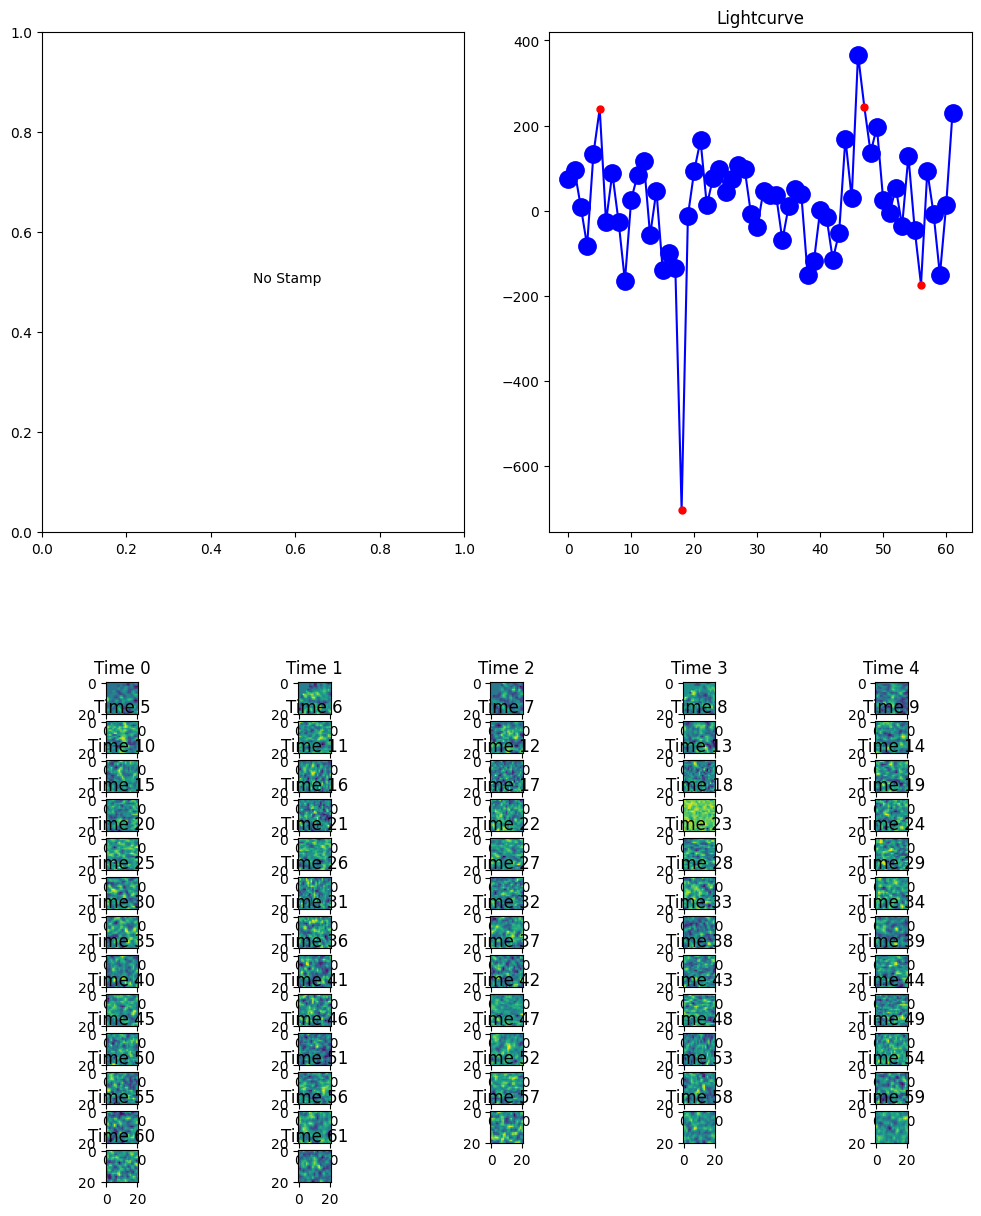

In [193]:
res_index = 66969
plot_result(res_index)


In [ ]:
df_pot = df[df['x'] > 0.1]

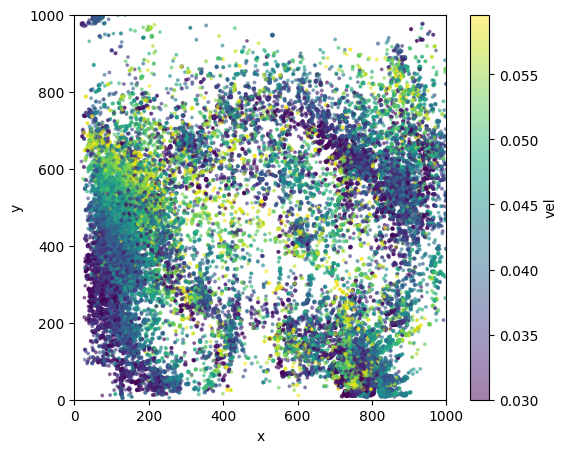

In [192]:
# plot df scatter points x,y with points size proportional to lh and color cluster label

plt.figure(figsize=(6,5))
plt.scatter(df.x, df.y, s=df.lh*1, c=df.vel, cmap='viridis', alpha=0.5)
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(0, size)
plt.ylim(0, size)
a = plt.colorbar()
a.set_label('vel')


In [ ]:
header['MAG5SIG'] 

In [99]:
trj0 = row0.trajectory
sky_pos = ATLAS_Parser.img_info.trajectory_to_skycoords(trj0)
for i, pos in enumerate(sky_pos):
    print(f"{i}: ({pos.ra.degree}, {pos.dec.degree})")
    ra_str = pos.ra.to_string(unit=u.hourangle, sep=':', pad=True, precision=2)
    dec_str = pos.dec.to_string(unit=u.degree, sep=':', alwayssign=True, pad=True, precision=1)
    print(f"{i}: ({ra_str}, {dec_str})")
sky_pos

NameError: name 'row0' is not defined

In [98]:
stamp = row0.stamp

# If the stamp needs to be reshaped, compute the width and reshape.
stamp_width = stamp.shape[0]
if len(stamp.shape) == 1:
    stamp_width = int(math.sqrt(stamp.shape[0]))
if stamp.size != stamp_width * stamp_width:
    raise ValueError("Expected square stamp, but found {stamp.shape}")

img = stamp.reshape(stamp_width, stamp_width)
img_c = cv2.GaussianBlur(img, img.shape, fwhm/2.355)


fig, ax = plt.subplots(1, 2, figsize=(8, 5))
c = ax[0].imshow(img, cmap='gray')
ax[0].set_title('stamp')
ax[1].imshow(img_c, cmap='gray')
ax[1].set_title('convolved stamp')
plt.show()


NameError: name 'row0' is not defined

In [ ]:
from kbmod.filters.stamp_filters import StampMomentsFilter
from kbmod.search import KB_NO_DATA, raw_image

# st = StampMomentsFilter(stamp.shape[0], 35.5, 35.5, 2.0, 0.3, 0.3)

In [ ]:
# normalize stamp stamp so the minumum value is 0 and the total flux is 1
moments = raw_image(img).find_central_moments()

print(f"m01: {moments.m01}")
print(f"m10: {moments.m10}")
print(f"m11: {moments.m11}")
print(f"m02: {moments.m02}")
print(f"m20: {moments.m20}")


# m01_thresh = moments['m01']
# m10_thresh = moments['m10']
# m11_thresh = moments['m11']
# m02_thresh = moments['m02']
# m20_thresh = moments['m20']

# print(f"m01_thresh: {m01_thresh}")
# print(f"m10_thresh: {m10_thresh}")
# print(f"m11_thresh: {m11_thresh}")
# print(f"m02_thresh: {m02_thresh}")
# print(f"m20_thresh: {m20_thresh}")

In [101]:
from kbmod.search import KB_NO_DATA, raw_image

result_index = 0
row = results.results[result_index]
stamp = row.stamp
stamp_width = stamp.shape[0]
if len(stamp.shape) == 1:
    stamp_width = int(math.sqrt(stamp.shape[0]))
if stamp.size != stamp_width * stamp_width:
    raise ValueError("Expected square stamp, but found {stamp.shape}")

img = stamp.reshape(stamp_width, stamp_width)

moments = raw_image(img).find_central_moments()

print(f"m01: {moments.m01}")
print(f"m10: {moments.m10}")
print(f"m11: {moments.m11}")
print(f"m02: {moments.m02}")
print(f"m20: {moments.m20}")

m01: 0.003250310430303216
m10: 0.1727941781282425
m11: 1.0976625680923462
m02: 4.087606906890869
m20: 7.859150409698486


In [ ]:
image = np.array(img)

# Create a grid of x, y coordinates
x = np.arange(image.shape[1])
y = np.arange(image.shape[0])
x, y = np.meshgrid(x, y)

# Create the 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
ax.plot_surface(x, y, image, cmap='viridis')

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Intensity')
ax.set_title('3D Image Intensity Plot')

plt.show()






In [ ]:
img.shape

In [ ]:
ResultsVisualizer.plot_single_stamp(row0.stamp)

-- --
# KNOWN OBJECTS CROSSMATCH
-- --

In [167]:
import requests
import numpy as np
from datetime import datetime
from urllib import request
import json
from astroquery.jplhorizons import Horizons
import pandas as pd
import multiprocessing

class AsteroidQuery:
    def __init__(self, code, ra_central, dec_central, m_lim, fov, date_ima, seeing, t_exp):
        self.code = code
        self.ra_central = ra_central
        self.dec_central = dec_central
        self.m_lim = m_lim
        self.fov = fov
        self.date_ima = date_ima
        self.seeing = seeing
        self.t_exp = t_exp
        self.jd = pd.Timestamp(datetime.strptime(self.date_ima, '%Y-%m-%dT%H:%M:%S')).to_julian_date()

    def query_ast_jpl(self):
        dec = self.dec_central
        if dec < 0:
            dec_str = 'M'
            dec = -1 * dec
        else:
            dec_str = ''
        dec_deg = np.floor(dec)
        dec_min = np.floor((dec - dec_deg) * 60)
        dec_sec = int((dec - dec_deg - dec_min / 60) * 3600)
        dec_str += '%02d-%02d-%02d' % (dec_deg, dec_min, dec_sec)

        ra = self.ra_central * 24 / 360
        ra_h = np.floor(ra)
        ra_min = np.floor((ra - ra_h) * 60)
        ra_sec = int((ra - ra_h - ra_min / 60) * 3600)
        ra_str = '%02d-%02d-%02d' % (ra_h, ra_min, ra_sec)

        query = 'https://ssd-api.jpl.nasa.gov/sb_ident.api?sb-kind=a&' + \
                'mpc-code=%s&' % self.code + \
                'obs-time=%s&' % self.date_ima + \
                'mag-required=false&two-pass=true&req-elem=false&' + \
                'vmag-lim=%.1f&' % self.m_lim + \
                'fov-ra-center=%s&' % ra_str + \
                'fov-dec-center=%s&' % dec_str + \
                'fov-ra-hwidth=%f&' % (self.fov * 0.5) + \
                'fov-dec-hwidth=%f' % (self.fov * 0.5)

        with request.urlopen(query) as url:
            data = json.load(url)

        d = data['data_second_pass']

        data = {'id': [],
                'jpl_RA': [],
                'jpl_DEC': [],
                'jpl_MAG': [],
                'jpl_rateRA': [],
                'jpl_rateDEC': [],
                'jpl_rate': [],
                'jpl_pa': []}
                
        for obj in d:
            desig, number, name = self.jpl_names(obj[0])
            data['id'].append(desig)

            ra = obj[1].split(':')
            ra = (float(ra[0]) + float(ra[1]) / 60 + float(ra[2]) / 3600) * 360 / 24
            dec = obj[2].split('\'')
            if dec[0][0] == '+':
                dec = float(dec[0].split(' ')[0][1:]) + float(dec[0].split(' ')[1]) / 60 + float(dec[1][:-1]) / 3600
            elif dec[0][0] == '-':
                dec = -1 * (float(dec[0].split(' ')[0][1:]) + float(dec[0].split(' ')[1]) / 60 + float(dec[1][:-1]) / 3600)

            data['jpl_RA'].append(ra)
            data['jpl_DEC'].append(dec)
            try: data['jpl_MAG'].append(float(obj[6]))
            except: data['jpl_MAG'].append(-999)
            data['jpl_rateRA'].append(float(obj[7]) / 60)
            data['jpl_rateDEC'].append(float(obj[8]) / 60)
            data['jpl_rate'].append(np.sqrt(float(obj[7]) ** 2 + float(obj[8]) ** 2) / 60)
            pa = np.arctan2(float(obj[7]), float(obj[8])) * 180 / np.pi
            if pa < 0:
                pa = 360 + pa
            data['jpl_pa'].append(pa)


        return pd.DataFrame(data)

    def query_ast_find_orb(self):

        if self.dec_central < 0:
            dec = '-%f' % abs(self.dec_central)
        else:
            dec_str = dec = '%f' % self.dec_central
        ra = self.ra_central

        radius = self.fov / 2 * 3600

        response = requests.post('http://10.0.203.2:5566/astcheck', json={'command': '%s %s %s %s -r %.2f -m %.1f' %
                                                                                 (self.date_ima, ra, dec, self.code, radius,
                                                                                  self.m_lim)})

        return response.json()['data']

    def query_ast_in_fov(self, max_jpl_query = 1):
        vel_thres = 1.5 * self.seeing / (self.t_exp / 3600)

        if self.dec_central < 0:
            dec = '-%f' % abs(self.dec_central)
        else:
            dec = '+%f' % self.dec_central
        radius = self.fov / 2 * 3600
        

        response = requests.post('http://10.0.203.2:5566/astcheck', json={'command': '%s %s %s %s -r%.2f -m%.1f -z%.6f' %
                                                                                   (self.date_ima, self.ra_central,
                                                                                    dec, self.code, radius,
                                                                                    self.m_lim, vel_thres)})

        top = '                           RA  (J2000)  dec       mag   dRA/dt    dDec/dt'
        bottom = 'The apparent motion and arc length for each object are shown,  followed'

        lines = response.text.split('\n')
        idx_top, idx_bottom = [i for i, s in enumerate(lines) if top in s or bottom in s]
        lines = lines[idx_top + 1:idx_bottom]
        if len(lines) == 0:
            return None
        else:
            data = {'id': [],
                    'jpl_RA': [],
                    'jpl_DEC': [],
                    'jpl_MAG': [],
                    'jpl_rateRA': [],
                    'jpl_rateDEC': [],
                    'jpl_rate': [],
                    'jpl_pa': []}

            names = [str(l[:25].strip()) for l in lines]
            print('Number of objects in the field: %d' % len(names))

            groups = [names[i:i + max_jpl_query] for i in range(0, len(names), max_jpl_query)]

            for g in groups:
                print('Querying JPL for %d objects' % len(g))

                pool = multiprocessing.Pool()
                results = pool.map(self.process_id, g)
                pool.close()
                pool.join()

                for r in results:
                    desig, number, name = self.jpl_names(r['targetname'][0])
                    if number is not None: data['id'].append(number)
                    else: data['id'].append(desig)
                    data['jpl_RA'].append(r['RA'][0])
                    data['jpl_DEC'].append(r['DEC'][0])
                    data['jpl_MAG'].append(r['V'][0])
                    data['jpl_rateRA'].append(r['RA_rate'][0] / 60)
                    data['jpl_rateDEC'].append(r['DEC_rate'][0] / 60)
                    data['jpl_rate'].append(np.sqrt(r['RA_rate'][0] ** 2 + r['DEC_rate'][0] ** 2) / 60)
                    pa = np.arctan2(r['RA_rate'][0], r['DEC_rate'][0]) * 180 / np.pi
                    if pa < 0:
                        pa = 360 + pa
                    data['jpl_pa'].append(pa)


            return pd.DataFrame(data)

    def check_asteroid(self, obj):
        t_exp = self.t_exp
        vel_thres = 1.5 * self.seeing / (t_exp / 3600)

        vel = np.sqrt(float(obj[7]) ** 2 + float(obj[8]) ** 2) / 3600

        ra = obj[1].split(':')
        ra = (float(ra[0]) + float(ra[1]) / 60 + float(ra[2]) / 3600) * 360 / 24
        dec = obj[2].split('\'')
        if dec[0][0] == '+':
            dec = float(dec[0][1:]) + float(dec[1][:-1]) / 60 + float(dec[2][:-1]) / 3600
        elif dec[0][0] == '-':
            dec = -1 * (float(dec[0][1:]) + float(dec[1][:-1]) / 60 + float(dec[2][:-1]) / 3600)

        if vel * t_exp > vel_thres:
            return (ra, dec), None, None
        else:
            sep_names = obj[0].split(' ')
            desig = (' ').join(sep_names[-2:])[1:-1]
            number = None
            name = None
            if len(sep_names) > 2:
                number = sep_names[0]
            if len(sep_names) > 3:
                name = sep_names[1]
            return [ra, dec], [desig, number, name], vel * 60

    def process_id(self, id):
        obj = Horizons(id=id, location=self.code, epochs=self.jd)
        eph = obj.ephemerides()
        eph_dict = eph.to_pandas().to_dict(orient='list')
        return eph_dict

    def jpl_names(self, name):
        sep_names = name.split(' ')
        number = None
        name = None
        if sep_names[0].startswith('C/'):
            desig = ' '.join(sep_names[:2])
        else:
            desig = (' ').join(sep_names[-2:])[1:-1]
            if len(sep_names) > 2:
                number = sep_names[0]
            if len(sep_names) > 3:
                name = sep_names[1]
        return desig, number, name

def find_known_asteroids(detections, asteroids, limit=300):

    ast = asteroids.assign(key=1)
    trans = detections.assign(key=1)
    cross_join = ast.merge(trans, on='key').drop('key', axis=1)

    cross_join['distance'] = ((cross_join['jpl_x'] - cross_join['x']) ** 2 + (cross_join['jpl_y'] - cross_join['y']) ** 2) ** 0.5

    cross_join = cross_join[cross_join.distance < limit].sort_values(by='distance').drop_duplicates(subset='id_x', keep='first', ignore_index=True)

    return cross_join#.dropna()

In [ ]:
df

In [ ]:
requests.post('http://10.0.203.2:5566/update_mpcorb')

In [168]:
file = sci_filelist[0]
res_file = os.path.join(ATLAS_Parser.warped_image_path, os.path.basename(file).replace('.fits.fz', '.fits'))
with fits.open(res_file, output_verify='silentfix') as hdul: new_header = hdul[0].header
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    header = fits.getheader(file, 1)
header = ATLAS_Parser.correct_header(header, new_header)

In [169]:
ra_central = crop_params['center_coords'][0]
dec_central = crop_params['center_coords'][1]
date_ima = header['DATE-OBS'].split('+')[0]
code = header['OBSERVAT']
scale = header['PIXSCALE']
seeing = header['SEEING']
mag_lim = 23
fov = np.sqrt(header['NAXIS1']**2 + header['NAXIS2']**2)*scale/3600
t_exp = header['EXPTIME']

AstQuery = AsteroidQuery(code, ra_central, dec_central, mag_lim, fov, date_ima, seeing, t_exp)
asteroid = AstQuery.query_ast_jpl()

In [16]:
date_ima

'2019-07-04T10:22:55'

In [170]:
head_tpv = header.copy()

def correct_header(header):
    # # Change CTYPE to TPV
    # header['CTYPE1'] = 'RA---TPV'
    # header['CTYPE2'] = 'DEC--TPV'

    # # Remove SIP coefficients
    # for keyword in list(header.keys()):
    #     if keyword.startswith(('A_', 'B_', 'AP_', 'BP_', 'A_ORDER', 'B_ORDER')):
    #         del header[keyword]
    # Change CTYPE back to TAN
    header['CTYPE1'] = 'RA---TAN-SIP'
    header['CTYPE2'] = 'DEC--TAN-SIP'

    # Remove PV coefficients
    for keyword in list(header.keys()):
        if keyword.startswith(('PV1_', 'PV2_')):
            del header[keyword]
    return header

head_tpv = correct_header(head_tpv)


In [171]:
wcs = WCS(head_tpv)

for a in range(len(asteroid)):
    x, y = wcs.all_world2pix(asteroid['jpl_RA'].iloc[a], asteroid['jpl_DEC'].iloc[a], 0)
    asteroid.loc[a, 'jpl_x'] = x
    asteroid.loc[a, 'jpl_y'] = y
    
# asteroid = asteroid.loc[(asteroid.jpl_x > 0) & (asteroid.jpl_x < header['NAXIS1']) & (asteroid.jpl_y > 0) & (asteroid.jpl_y < header['NAXIS2'])]
# asteroid


In [ ]:
pd.DataFrame(asteroid.to_dict('records'))

In [17]:
asteroid

,id,jpl_RA,jpl_DEC,jpl_MAG,jpl_rateRA,jpl_rateDEC,jpl_rate,jpl_pa,jpl_x,jpl_y
0,A896 YD,283.603625,-23.534917,13.8,-0.548500,-0.146533,0.567736,255.042580,281.565645,2258.258780
1,1948 SA,283.709083,-21.617583,15.9,-0.495833,-0.048767,0.498226,264.382857,46.700894,5974.379788
2,6578 P-L,280.711000,-23.152917,17.0,-0.628333,-0.093433,0.635242,261.542079,5422.049269,3002.493330
3,1976 UW15,281.137375,-24.793806,15.8,-0.535167,-0.077500,0.540749,261.760011,4645.929379,-172.210503
4,1976 YX1,281.546417,-23.891722,17.3,-0.499500,-0.038500,0.500982,265.592523,3930.440169,1582.806145
...,...,...,...,...,...,...,...,...,...,...
1532,2023 FQ14,279.676250,-24.874889,19.9,-0.780667,-1.055167,1.312561,216.495944,7228.212169,-370.581196
1533,2023 FX35,281.271000,-21.260611,20.5,-0.556333,-0.256500,0.612617,245.247722,4446.905634,6678.288488
1534,2023 FC38,281.931917,-22.993222,21.3,-0.612167,0.145617,0.629247,283.380336,3249.807949,3321.917598
1535,2023 JN17,282.508708,-21.832694,21.2,-0.579333,0.022867,0.579784,272.260329,2215.047014,5567.336051


In [172]:
df['jpl_id'] = np.nan
limit = 5
speed_limit = 0.2
#pa_limit = 0.25
df_ast = pd.DataFrame(asteroid.to_dict('records'))
df_ast = df_ast.loc[df_ast.jpl_MAG > 0]
for a,ast in enumerate(asteroid.to_dict('records')):
    distance = np.sqrt((df.x.to_numpy() - ast['jpl_x'])**2 + (df.y.to_numpy() - ast['jpl_y'])**2)
    dist_min_id = np.argmin(distance)
    pa = np.arctan2(df.loc[dist_min_id,'vy'], df.loc[dist_min_id,'vx']) * 180/np.pi
    if pa < 0:
        pa = 360 + pa
    if np.min(distance) < limit and np.abs(df.loc[dist_min_id, 'vel'] - ast['jpl_rate'])/ast['jpl_rate'] < speed_limit:# and np.abs(pa - ast['jpl_pa'])/ast['jpl_pa'] < pa_limit:
        df.loc[dist_min_id, 'jpl_id'] = ast['id']
        df.loc[dist_min_id, 'jpl_x'] = ast['jpl_x']
        df.loc[dist_min_id, 'jpl_y'] = ast['jpl_y']
        df.loc[dist_min_id, 'jpl_ra'] = ast['jpl_RA']
        df.loc[dist_min_id, 'jpl_dec'] = ast['jpl_DEC']
        df.loc[dist_min_id, 'jpl_mag'] = ast['jpl_MAG']
        df.loc[dist_min_id, 'jpl_rate_ra'] = ast['jpl_rateRA']
        df.loc[dist_min_id, 'jpl_rate_dec'] = ast['jpl_rateDEC']
        df.loc[dist_min_id, 'jpl_rate'] = ast['jpl_rate']
        df.loc[dist_min_id, 'jpl_pa'] = ast['jpl_pa']
        df.loc[dist_min_id, 'jpl_sep'] = distance[dist_min_id]

    df_ast.loc[a, 'id'] = df.loc[dist_min_id, 'id']
    df_ast.loc[a, 'x'] = df.loc[dist_min_id, 'x']
    df_ast.loc[a, 'y'] = df.loc[dist_min_id, 'y']
    df_ast.loc[a, 'lh'] = df.loc[dist_min_id, 'lh']
    df_ast.loc[a, 'vx'] = df.loc[dist_min_id, 'vx']
    df_ast.loc[a, 'vy'] = df.loc[dist_min_id, 'vy']
    df_ast.loc[a, 'vel'] = df.loc[dist_min_id, 'vel']
    df_ast.loc[a, 'ang'] = df.loc[dist_min_id, 'ang']
    df_ast.loc[a, 'sep'] = distance[dist_min_id]




In [35]:
np.abs(pa - ast['jpl_pa'])/ast['jpl_pa']

0.09497672609690665

In [33]:
df.loc[dist_min_id, 'ang']

-2.6275136847038225

In [173]:
len(df.dropna())

30

-- --
STAMP EMBEDDING
-- --



In [24]:
df

NameError: name 'df' is not defined

In [29]:
import cv2

features = []
def compute_features(stamp):
    # moments
    m = cv2.moments(stamp)
    # elongation
    mu20 = m['mu20'] / m['m00']
    mu02 = m['mu02'] / m['m00']
    mu11 = m['mu11'] / m['m00']
    lambda1 = 0.5 * (mu20 + mu02 + np.sqrt(4*mu11**2 + (mu20 - mu02)**2))
    lambda2 = 0.5 * (mu20 + mu02 - np.sqrt(4*mu11**2 + (mu20 - mu02)**2))
    elongation = np.sqrt(lambda1 / lambda2)
    m['elongation'] = elongation
    return m

# iterate over all stamps
for id in range(len(df)):
    stamp = coadded_stamp_sum[id,:]
    m = compute_features(stamp)
    for key in m.keys():
        df.loc[id, key] = m[key]

    #print('%i/%i' % (id, len(df)), end='\r')


/tmp/ipykernel_25/4074242459.py:13: RuntimeWarning: invalid value encountered in sqrt
  elongation = np.sqrt(lambda1 / lambda2)


In [115]:
from kbmod.search import KB_NO_DATA, raw_image


moments = np.zeros((len(df), 5))
def compute_kbmod_moments(stamp):
    # stamp_width = stamp.shape[0]
    # if len(stamp.shape) == 1:
    #     stamp_width = int(math.sqrt(stamp.shape[0]))
    # if stamp.size != stamp_width * stamp_width:
    #     raise ValueError("Expected square stamp, but found {stamp.shape}")

    # img = stamp.reshape(stamp_width, stamp_width)

    moments = raw_image(stamp).find_central_moments()

    return moments

# iterate over all stamps
for j,id in enumerate(range(len(df))):
    stamp = coadded_stamp_sum[id,:]
    m = compute_kbmod_moments(stamp)
    moments[j,:] = [m.m01, m.m10, m.m11, m.m02, m.m20]

In [117]:
moments

array([[-1.32687226e-01, -1.14999255e-02, -1.92775968e-02,
         4.90196323e+00,  4.84353209e+00],
       [ 5.47151208e-01, -3.36977124e-01, -4.02068287e-01,
         6.15658998e+00,  4.98471069e+00],
       [ 1.73354357e-01,  6.69744015e-02,  2.08875105e-01,
         6.96615362e+00,  7.59309864e+00],
       ...,
       [ 1.05282865e-01, -2.16420740e-01,  1.31488591e-02,
         3.48285294e+01,  3.59331818e+01],
       [ 4.48514819e-02,  6.39605820e-02,  4.05635953e-01,
         3.63366394e+01,  3.63544235e+01],
       [ 8.75825435e-03, -1.61920041e-01,  3.59818101e-01,
         3.57717056e+01,  3.58957443e+01]])

In [103]:
from kbmod.search import KB_NO_DATA, raw_image


moments = np.zeros((len(df), 5))
def compute_kbmod_moments(stamp):
    stamp_width = stamp.shape[0]
    if len(stamp.shape) == 1:
        stamp_width = int(math.sqrt(stamp.shape[0]))
    if stamp.size != stamp_width * stamp_width:
        raise ValueError("Expected square stamp, but found {stamp.shape}")

    img = stamp.reshape(stamp_width, stamp_width)

    moments = raw_image(img).find_central_moments()

    return moments

In [111]:
compute_kbmod_moments(stamp).m10

0.1727941781282425

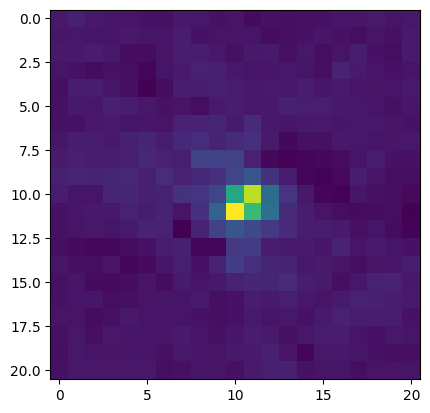

In [54]:
plt.imshow(coadded_stamp_sum[60000,:], cmap='viridis')

In [ ]:
        stamp = row.stamp.reshape([self.width, self.width])
        moments = raw_image(stamp).find_central_moments()

In [89]:
df_ast

,id,jpl_RA,jpl_DEC,jpl_MAG,jpl_rateRA,jpl_rateDEC,jpl_rate,jpl_pa,jpl_x,jpl_y,x,y,lh,vx,vy,vel,ang,sep
0,22,283.603625,-23.534917,13.8,-0.548500,-0.146533,0.567736,255.042580,281.565645,2258.258780,286.0,2262.0,858.821533,0.588878,-0.378448,0.70,-0.571198,5.801744
1,9795,283.709083,-21.617583,15.9,-0.495833,-0.048767,0.498226,264.382857,46.700894,5974.379788,56.0,5971.0,80.011452,0.555690,-0.720631,0.91,-0.913918,9.894258
2,4959,280.711000,-23.152917,17.0,-0.628333,-0.093433,0.635242,261.542079,5422.049269,3002.493330,5422.0,3002.0,107.555855,0.448045,-0.104188,0.46,-0.228479,0.495785
3,594990,281.137375,-24.793806,15.8,-0.535167,-0.077500,0.540749,261.760011,4645.929379,-172.210503,4609.0,2.0,5.341508,-0.374421,-0.211445,0.43,-2.627514,178.081662
4,3505,281.546417,-23.891722,17.3,-0.499500,-0.038500,0.500982,265.592523,3930.440169,1582.806145,3930.0,1583.0,124.115807,0.490000,0.000000,0.49,0.000000,0.480966
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1532,624667,279.676250,-24.874889,19.9,-0.780667,-1.055167,1.312561,216.495944,7228.212169,-370.581196,6143.0,5.0,5.610503,-2.139240,3.128538,3.79,2.170555,1148.366965
1533,449374,281.271000,-21.260611,20.5,-0.556333,-0.256500,0.612617,245.247722,4446.905634,6678.288488,4389.0,6140.0,8.916575,0.151418,-0.466018,0.49,-1.256637,541.394088
1534,173488,281.931917,-22.993222,21.3,-0.612167,0.145617,0.629247,283.380336,3249.807949,3321.917598,3252.0,3319.0,15.346592,-0.294696,-0.270470,0.40,-2.399034,3.649311
1535,634643,282.508708,-21.832694,21.2,-0.579333,0.022867,0.579784,272.260329,2215.047014,5567.336051,2220.0,5491.0,5.358231,-1.628295,0.919541,1.87,2.627514,76.496567


In [12]:
# Load stamps
all_stamps = np.load(os.path.join(res_filepath, "all_ps_%s.npy" % results_suffix))

In [14]:
coadded_stamp_sum = np.median(all_stamps, axis=1)
coadded_stamp_sum.shape

(648099, 21, 21)

In [100]:
df

In [97]:
# sum negative values for each stamp
n_neg_values = np.sum(coadded_stamp_sum < 0, axis=(1,2))
n_neg_values.shape

(648099,)

In [58]:
feature_df.iloc[0]

id            0.000000e+00
vel           4.000000e-01
lh            9.607398e+02
m00           2.008041e+05
m10           2.005685e+06
m01           1.980854e+06
m20           2.087574e+07
m11           1.978103e+07
m02           2.039111e+07
m30           2.256088e+08
m21           2.059109e+08
m12           2.036915e+08
m03           2.180142e+08
mu20          8.424321e+05
mu11         -4.268876e+03
mu02          8.507522e+05
nu20          2.089247e-05
nu11         -1.058689e-07
nu02          2.109881e-05
nu30          1.480310e-08
nu21          3.602375e-09
nu12          5.754081e-09
nu03          4.387025e-09
elongation    1.007066e+00
Name: 0, dtype: float64

In [31]:
from sklearn.preprocessing import StandardScaler
feature_df = df[['id', 'vel', 'lh', 'm00', 'm10', 'm01', 'm20', 'm11', 'm02', 'm30', 'm21', 'm12', 'm03', 'mu20', 'mu11', 'mu02', 'nu20', 'nu11', 'nu02', 'nu30', 'nu21', 'nu12', 'nu03', 'elongation']].dropna()
feature_df.index = range(len(feature_df))
feature_array = feature_df.to_numpy()
norm_feature_array = (feature_array - np.mean(feature_array, axis=0)) / np.std(feature_array, axis=0)

scaler = StandardScaler()
#norm_feature_array = scaler.fit_transform(feature_array)


In [360]:
feature_df[feature_df.loc[:,'nu20'] < -1e10]

,id,vel,lh,m00,m10,m01,m20,m11,m02,m30,...,mu11,mu02,nu20,nu11,nu02,nu30,nu21,nu12,nu03,elongation
201532,287619,0.43,11.08971,0.392841,41174.142792,-5659.948799,180014.819637,389068.130314,-630290.844059,-6.210753e+06,...,5.936150e+08,-8.217731e+07,-2.796277e+10,3.846547e+09,-5.324981e+08,9.351911e+15,-1.286445e+15,1.775261e+14,-2.457542e+13,0.010772


Finding positions of trajectory lh: 32.562683 flux: 1202.856812 x: 3057 y: 2108 x_v: 26.500626 y_v: 308.541443 obs_count: 15
0.4000000022282432 355.09091323649926


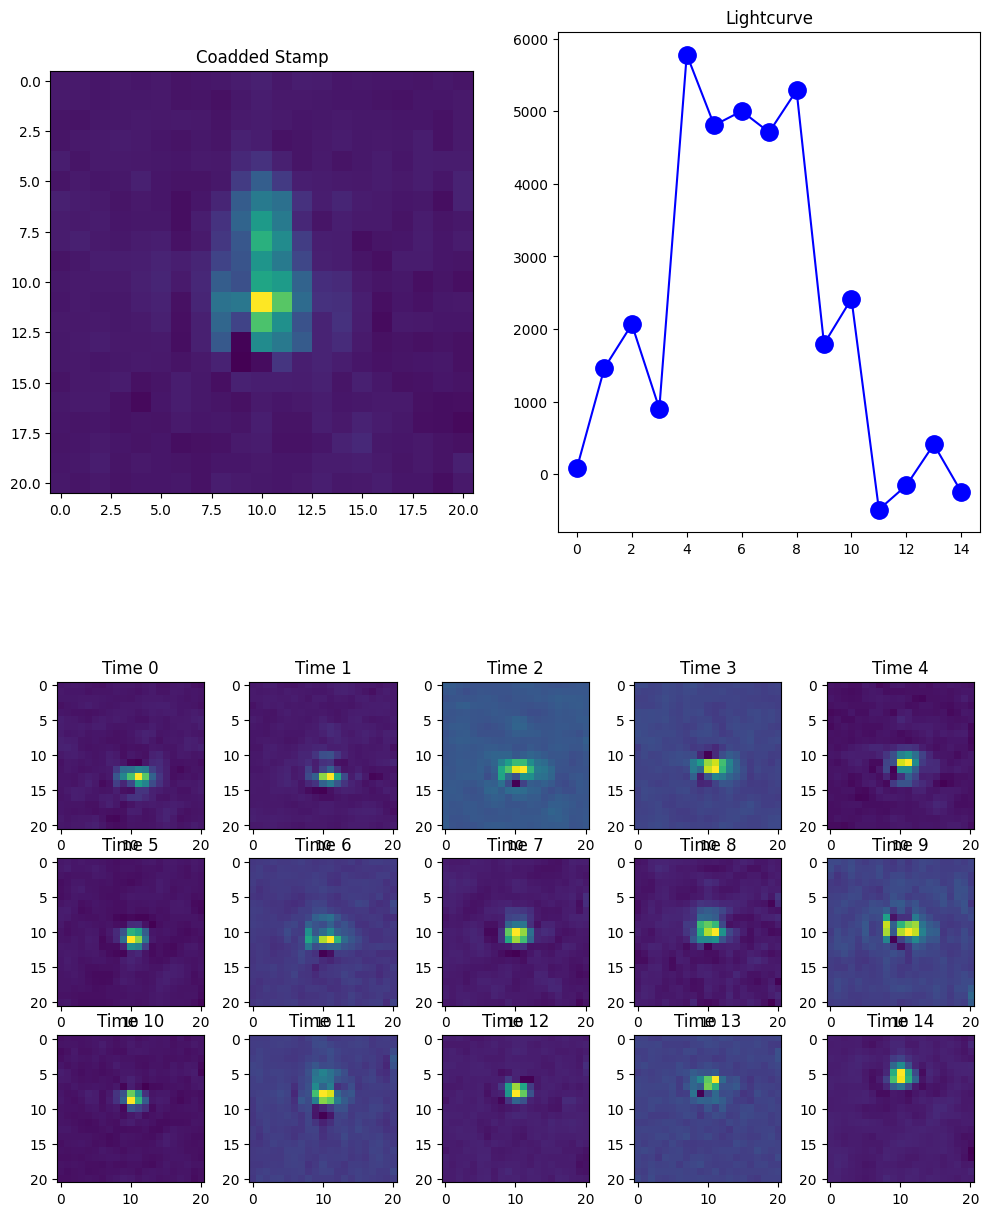

In [56]:
plot_result(80000)

In [82]:
feature_df.iloc[0]

id            0.000000e+00
vel           4.000000e-01
lh            9.607398e+02
m00           2.008041e+05
m10           2.005685e+06
m01           1.980854e+06
m20           2.087574e+07
m11           1.978103e+07
m02           2.039111e+07
m30           2.256088e+08
m21           2.059109e+08
m12           2.036915e+08
m03           2.180142e+08
mu20          8.424321e+05
mu11         -4.268876e+03
mu02          8.507522e+05
nu20          2.089247e-05
nu11         -1.058689e-07
nu02          2.109881e-05
nu30          1.480310e-08
nu21          3.602375e-09
nu12          5.754081e-09
nu03          4.387025e-09
elongation    1.007066e+00
Name: 0, dtype: float64

In [122]:
feature_df

,id,vel,lh,m00,m10,m01,m20,m11,m02,m30,...,mu11,mu02,nu20,nu11,nu02,nu30,nu21,nu12,nu03,elongation
0,0,0.40,960.739807,200804.086174,2.005685e+06,1.980854e+06,2.087574e+07,1.978103e+07,2.039111e+07,2.256088e+08,...,-4268.876376,850752.230048,0.000021,-1.058689e-07,0.000021,1.480310e-08,3.602375e-09,5.754081e-09,4.387025e-09,1.007066
1,1,0.43,960.411865,192227.683178,1.855456e+06,2.030774e+06,1.865231e+07,1.955981e+07,2.239106e+07,1.945067e+08,...,-42013.003146,937098.096016,0.000020,-1.136977e-06,0.000025,7.973253e-09,-1.029893e-08,7.924003e-09,-2.723925e-08,1.135111
2,2,0.40,1184.040894,175444.928588,1.767439e+06,1.788071e+06,1.859856e+07,1.805111e+07,1.888961e+07,2.028144e+08,...,38021.267979,666245.586607,0.000026,1.235222e-06,0.000022,-4.126957e-08,5.986063e-10,-1.724612e-08,7.955722e-09,1.107174
3,3,0.40,1083.207764,160303.299825,1.609799e+06,1.714006e+06,1.679023e+07,1.723364e+07,1.906818e+07,1.810473e+08,...,21237.340147,741574.319319,0.000024,8.264474e-07,0.000029,-9.912638e-09,8.734414e-10,-1.289938e-08,-2.159819e-08,1.095912
4,4,0.40,1074.428467,153086.435006,1.613864e+06,1.545281e+06,1.781568e+07,1.630047e+07,1.619267e+07,2.044101e+08,...,9843.651446,594325.941179,0.000034,4.200324e-07,0.000025,-3.453139e-08,-6.728535e-09,-1.236920e-08,-3.983553e-09,1.162479
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412399,648077,0.70,5.000420,815.266036,8.885608e+03,9.148398e+03,1.166357e+05,9.215805e+04,1.200367e+05,1.689746e+06,...,-7550.611554,17379.219098,0.029776,-1.136013e-02,0.026148,-6.786221e-04,-8.620228e-05,8.703751e-04,6.025644e-05,1.548550
412400,648083,1.06,5.000356,1007.987450,1.063468e+04,9.311192e+03,1.422530e+05,9.341965e+04,1.185244e+05,2.102433e+06,...,-4817.218391,32513.091989,0.029578,-4.741176e-03,0.032000,-1.008477e-03,-8.397161e-04,-5.064466e-04,1.760509e-03,1.173850
412401,648091,0.64,5.000151,465.659513,3.183219e+03,4.724993e+03,3.167956e+04,3.464735e+04,5.662792e+04,3.849819e+05,...,2347.605597,8683.973452,0.045745,1.082650e-02,0.040048,7.011339e-03,1.237941e-02,-3.108309e-03,6.487838e-03,1.306243
412402,648095,0.46,6.111823,228.497491,4.211959e+03,1.669223e+03,5.949617e+04,3.673218e+04,8.913259e+03,8.770988e+05,...,5962.920584,-3280.768450,-0.347514,1.142079e-01,-0.062837,5.692875e-01,-2.215915e-01,2.339298e-01,-7.064010e-02,0.241887


[]

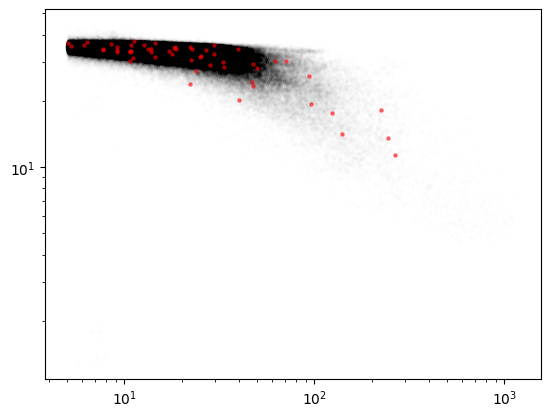

In [131]:
variable = 4
# plt.scatter(feature_df.lh, feature_df[variable]/feature_df.m00, s=5, c='k', alpha=0.02)
# plt.scatter(feature_df.lh.iloc[embedding_id], feature_df[variable].iloc[embedding_id]/feature_df.m00.iloc[embedding_id], s=5, c='r', alpha=0.5)
plt.scatter(feature_df.lh, moments[feature_df.id,variable], s=5, c='k', alpha=0.002)
plt.scatter(feature_df.lh.iloc[embedding_id], moments[embedding_id,variable], s=5, c='r', alpha=0.5)
plt.loglog()

(array([2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1.,
        0., 0., 0., 1., 1., 0., 1., 2., 3., 2., 1., 2., 0., 2., 0., 1., 0.,
        1., 1., 4., 1., 1., 1., 2., 0., 1., 0., 0., 0., 2., 2., 0., 1., 0.,
        2., 0., 0., 2., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 2., 1., 0.,
        0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1.]),
 array([-0.4826431 , -0.47243685, -0.4622306 , -0.45202435, -0.44181809,
        -0.43161184, -0.42140559, -0.41119934, -0.40099309, -0.39078684,
        -0.38058059, -0.37037434, -0.36016809, -0.34996184, -0.33975559,
        -0.32954933, -0.31934308, -0.30913683, -0.29893058, -0.28872433,
        -0.27851808, -0.26831183, -0.25810558, -0.24789933, -0.23769308,
        -0.22748683, -0.21728058, -0.20707432, -0.19686807, -0.18666182,
        -0.17645557, -0.16624932, -0.15604307, -0.14583682, -0.13563057,
        -0.12542432, -0.11521807, -0.10

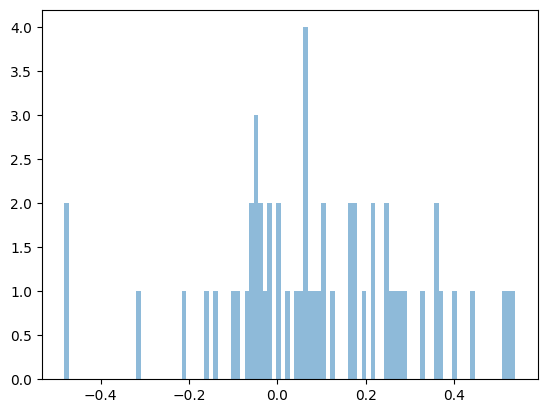

In [128]:
plt.hist(moments[embedding_id,variable], bins=100, alpha=0.5)

In [75]:
feature_df.iloc[embedding_id].sort_values(by=variable)

,id,vel,lh,m00,m10,m01,m20,m11,m02,m30,...,mu11,mu02,nu20,nu11,nu02,nu30,nu21,nu12,nu03,elongation
109100,148431,0.61,18.549629,93.336179,186.457299,2084.557283,-3.400836e+04,1.185819e+04,1.763839e+02,-1.014533e+06,...,7693.873889,-46379.829689,-3.946540,0.883171,-5.323891,-9.614941e+00,6.550821e+00,-6.458491e+00,1.895346e+01,0.781540
328483,506077,0.55,10.867720,411.129720,-1932.119848,5233.575249,-6.736197e+04,-2.402145e+04,6.157852e+04,-1.488459e+06,...,573.937947,-5043.540922,-0.452246,0.003396,-0.029839,-7.363064e-01,9.979898e-03,-4.551662e-02,1.110701e-02,0.256738
380946,590421,0.70,6.336203,262.462533,1644.421662,3553.718673,9.308658e+03,2.081231e+04,3.611058e+04,-4.300578e+04,...,-1453.010535,-12006.442198,-0.014433,-0.021093,-0.174293,-7.963134e-02,-2.635059e-02,9.287823e-03,1.088952e-01,0.257044
90971,121612,0.73,17.779802,610.761580,5331.726379,3513.775878,1.299112e+04,3.215410e+04,-1.084173e+04,-5.716536e+05,...,1480.110569,-31056.851304,-0.089947,0.003968,-0.083256,-1.076612e-02,-1.230309e-02,2.497889e-03,-4.549917e-02,0.941762
43371,55455,0.49,33.358948,563.306623,5646.183174,6752.253580,4.531756e+04,7.153246e+04,6.377584e+04,1.842019e+05,...,3852.696561,-17162.185646,-0.035535,0.012142,-0.054086,-5.840908e-03,9.521255e-04,-3.186355e-03,1.387488e-02,0.701038
266760,407275,0.58,9.186574,361.163493,3180.464645,2953.928003,3.363804e+04,2.269308e+04,2.636996e+04,3.889356e+05,...,-3319.688766,2210.009018,0.043165,-0.025450,0.016943,-2.601953e-03,-1.218430e-02,4.771513e-03,-8.088881e-03,6.417204
176693,256813,0.61,13.713564,1690.745650,18429.786440,17349.853970,2.459049e+05,1.786298e+05,2.101330e+05,3.565454e+06,...,-10490.336473,32094.692330,0.015746,-0.003670,0.011227,-8.194982e-04,-4.363585e-04,4.237402e-04,-4.447377e-04,1.392544
241297,365877,0.70,10.661303,937.946791,9227.984639,8101.206188,1.126506e+05,7.956338e+04,9.345262e+04,1.517086e+06,...,-140.291203,23481.123220,0.024849,-0.000159,0.026691,-7.938159e-04,-1.861417e-03,2.186085e-03,-8.894145e-04,1.036942
360404,557389,0.61,5.249934,1752.248419,17515.399108,14594.002492,2.098235e+05,1.451377e+05,1.585338e+05,2.693080e+06,...,-743.328321,36984.302708,0.011315,-0.000242,0.012046,-7.689658e-04,-1.510435e-05,-8.738105e-05,7.084832e-04,1.038261
376947,583867,0.49,5.022143,1105.364245,12523.863316,9810.929763,1.717094e+05,1.169499e+05,1.191657e+05,2.589871e+06,...,5791.289201,32086.437153,0.024400,0.004740,0.026261,-7.674858e-04,-8.613032e-04,2.360804e-04,-3.379508e-04,1.212947


Finding positions of trajectory lh: 7.675263 flux: 180.978973 x: 3757 y: 5592 x_v: 416.827667 y_v: -267.878632 obs_count: 13
0.6399999987591187 237.27275104242412


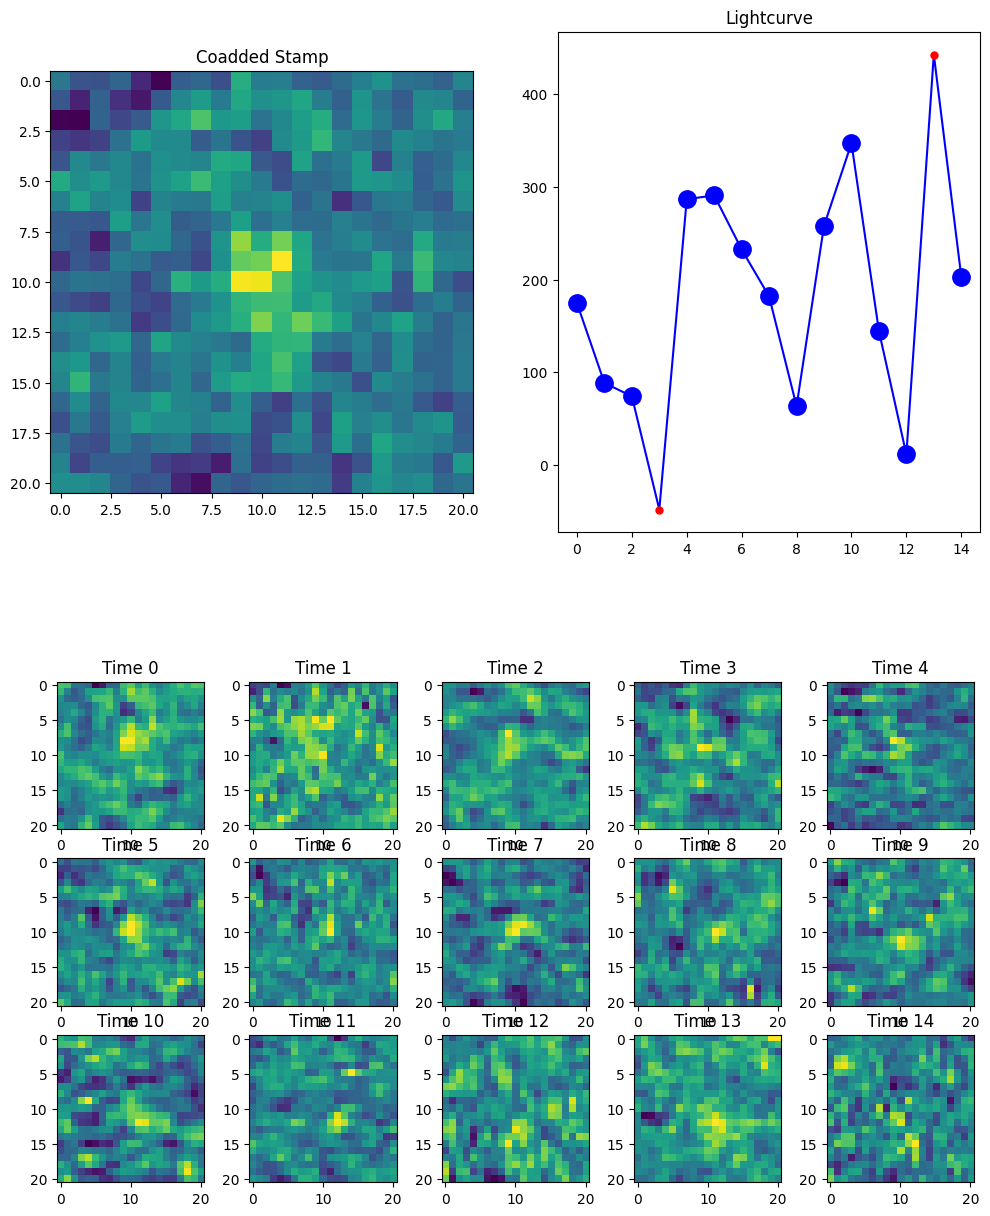

In [77]:
plot_result(483039)

In [33]:
embedding_id = []
for id in df.dropna().id:
    df_features = feature_df.loc[feature_df.id == id]
    embedding_id.append(df_features.index[0])


In [124]:
    df_features = feature_df.loc[feature_df.id == id]
    feats = df_features.to_numpy()[:,1:]
    
    np.where(np.all(feature_array == feats, axis=1))[0][0]

486

In [42]:
feature_df

,id,vel,lh,m00,m10,m01,m20,m11,m02,m30,...,mu11,mu02,nu20,nu11,nu02,nu30,nu21,nu12,nu03,elongation
0,0,0.40,960.739807,200804.086174,2.005685e+06,1.980854e+06,2.087574e+07,1.978103e+07,2.039111e+07,2.256088e+08,...,-4268.876376,850752.230048,0.000021,-1.058689e-07,0.000021,1.480310e-08,3.602375e-09,5.754081e-09,4.387025e-09,1.007066
1,1,0.43,960.411865,192227.683178,1.855456e+06,2.030774e+06,1.865231e+07,1.955981e+07,2.239106e+07,1.945067e+08,...,-42013.003146,937098.096016,0.000020,-1.136977e-06,0.000025,7.973253e-09,-1.029893e-08,7.924003e-09,-2.723925e-08,1.135111
2,2,0.40,1184.040894,175444.928588,1.767439e+06,1.788071e+06,1.859856e+07,1.805111e+07,1.888961e+07,2.028144e+08,...,38021.267979,666245.586607,0.000026,1.235222e-06,0.000022,-4.126957e-08,5.986063e-10,-1.724612e-08,7.955722e-09,1.107174
3,3,0.40,1083.207764,160303.299825,1.609799e+06,1.714006e+06,1.679023e+07,1.723364e+07,1.906818e+07,1.810473e+08,...,21237.340147,741574.319319,0.000024,8.264474e-07,0.000029,-9.912638e-09,8.734414e-10,-1.289938e-08,-2.159819e-08,1.095912
4,4,0.40,1074.428467,153086.435006,1.613864e+06,1.545281e+06,1.781568e+07,1.630047e+07,1.619267e+07,2.044101e+08,...,9843.651446,594325.941179,0.000034,4.200324e-07,0.000025,-3.453139e-08,-6.728535e-09,-1.236920e-08,-3.983553e-09,1.162479
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412399,648077,0.70,5.000420,815.266036,8.885608e+03,9.148398e+03,1.166357e+05,9.215805e+04,1.200367e+05,1.689746e+06,...,-7550.611554,17379.219098,0.029776,-1.136013e-02,0.026148,-6.786221e-04,-8.620228e-05,8.703751e-04,6.025644e-05,1.548550
412400,648083,1.06,5.000356,1007.987450,1.063468e+04,9.311192e+03,1.422530e+05,9.341965e+04,1.185244e+05,2.102433e+06,...,-4817.218391,32513.091989,0.029578,-4.741176e-03,0.032000,-1.008477e-03,-8.397161e-04,-5.064466e-04,1.760509e-03,1.173850
412401,648091,0.64,5.000151,465.659513,3.183219e+03,4.724993e+03,3.167956e+04,3.464735e+04,5.662792e+04,3.849819e+05,...,2347.605597,8683.973452,0.045745,1.082650e-02,0.040048,7.011339e-03,1.237941e-02,-3.108309e-03,6.487838e-03,1.306243
412402,648095,0.46,6.111823,228.497491,4.211959e+03,1.669223e+03,5.949617e+04,3.673218e+04,8.913259e+03,8.770988e+05,...,5962.920584,-3280.768450,-0.347514,1.142079e-01,-0.062837,5.692875e-01,-2.215915e-01,2.339298e-01,-7.064010e-02,0.241887


In [112]:
import umap
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
features_standardized = scaler.fit_transform(feature_array)

# Now you can apply UMAP on the standardized features
reducer = umap.UMAP()
embedding = reducer.fit_transform(features_standardized)


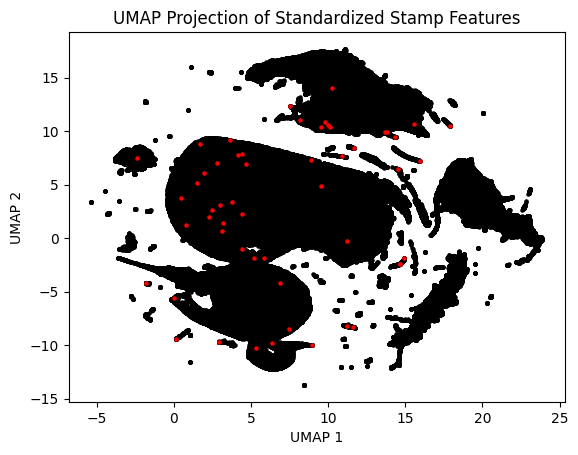

In [126]:
plt.scatter(embedding[:, 0], embedding[:, 1], s=5, c='k')
plt.scatter(embedding[embedding_id, 0], embedding[embedding_id, 1], s=5, c='r')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title('UMAP Projection of Standardized Stamp Features')
plt.show()

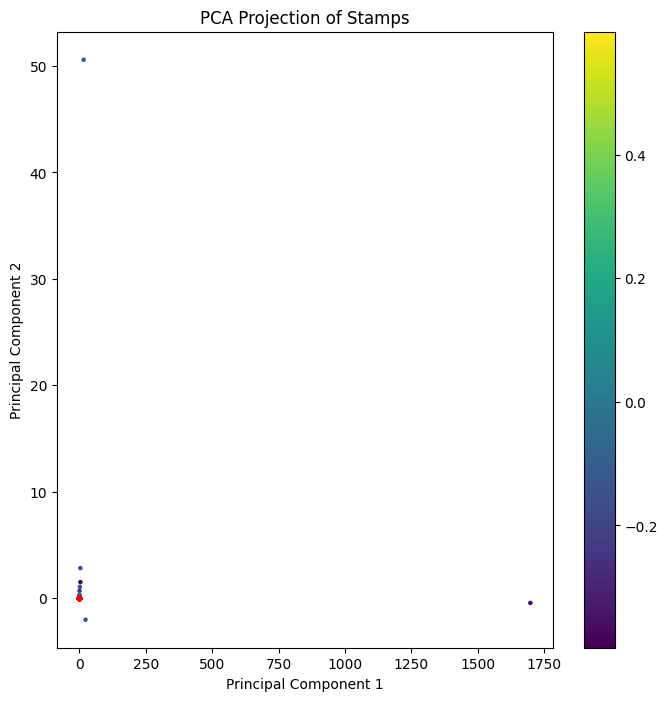

In [39]:
from sklearn.decomposition import PCA

# Apply PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(norm_feature_array[:,-8:-1])

# Visualize the results
plt.figure(figsize=(8, 8))
# plt.scatter(principal_components[:, 0], principal_components[:, 1], s=5,alpha=0.005, c='k')
# plot with color based on column 0 in log scale
plt.scatter(principal_components[:, 0], principal_components[:, 1], s=5, c=np.log10(feature_array[:,1]), cmap='viridis')
plt.colorbar()
plt.scatter(principal_components[embedding_id, 0], principal_components[embedding_id, 1], s=10, c = 'r')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Projection of Stamps')
# plt.xlim(-.005,.005)
# plt.ylim(-.005,.005)


plt.show()

In [40]:
principal_components[embedding_id, 0], principal_components[embedding_id, 1]

(array([-0.00423858, -0.00423858, -0.00423858, -0.00423858, -0.00423858,
        -0.00423858, -0.00423858, -0.00423858, -0.00423858, -0.00423858,
        -0.00423858, -0.00423858, -0.00423858, -0.00423858, -0.00423858,
        -0.00423858, -0.00423858, -0.00423858, -0.00423858, -0.00423858,
        -0.00423858, -0.00423858, -0.00423858, -0.00423858, -0.00423858,
        -0.00423858, -0.00423858, -0.00423858, -0.00423858, -0.00423858,
        -0.00423858, -0.00423858, -0.00423858, -0.00423858, -0.00423858,
        -0.00423858, -0.00423858, -0.00423858, -0.00423858, -0.00423858,
        -0.00423858, -0.00423858, -0.00423858, -0.00423858, -0.00423858,
        -0.00423858, -0.00423858, -0.00423858, -0.00423858, -0.00423858,
        -0.00423858, -0.00423858, -0.00423858, -0.00423858, -0.00423858,
        -0.00423858]),
 array([-0.00013467, -0.00013467, -0.00013467, -0.00013467, -0.00013467,
        -0.00013467, -0.00013467, -0.00013467, -0.00013467, -0.00013467,
        -0.00013467, -0.0001

In [334]:
feature_array.size

10866120

In [330]:
principal_components[:10, 0], principal_components[:10, 1]

(array([-2.09655665e+10, -2.09655665e+10, -2.09655665e+10, -2.09655665e+10,
        -2.09655665e+10, -2.09655665e+10, -2.09655665e+10, -2.09655665e+10,
        -2.09655665e+10, -2.09655665e+10]),
 array([-7.59792412e+08, -7.59792411e+08, -7.59792411e+08, -7.59792411e+08,
        -7.59792411e+08, -7.59792411e+08, -7.59792411e+08, -7.59792411e+08,
        -7.59792411e+08, -7.59792411e+08]))

In [2]:
principal_components.shape

NameError: name 'principal_components' is not defined

In [46]:
feature_df.nu20.iloc[embedding_id]

509         0.000405
622        -0.000600
758        -0.000776
2268        0.000497
2977       -0.004612
5190        0.003019
5336        0.002968
10236       0.004499
12779      -0.035364
17457       0.005040
19938       0.005444
22290       0.001581
22694       0.006572
31719       0.007132
32415       0.002008
43371      -0.035535
45262       0.008641
53311       0.003457
56433       0.011305
56438       0.009226
56904      -0.002079
64384       0.012328
72303       0.009850
74019       0.013008
80394       0.008872
88854       0.016465
89981    -125.802749
90971      -0.089947
91797       0.012757
109100     -3.946540
109562      0.016753
121246      0.013800
123663      0.009494
125275      0.005773
168501      0.020200
169855      0.011519
171804      0.012223
176693      0.015746
178910      0.016584
215115      0.010839
219837      0.017756
229173      0.009803
236160      0.030059
241297      0.024849
244584      0.020316
252567      0.039198
257100      0.011873
266760      0

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

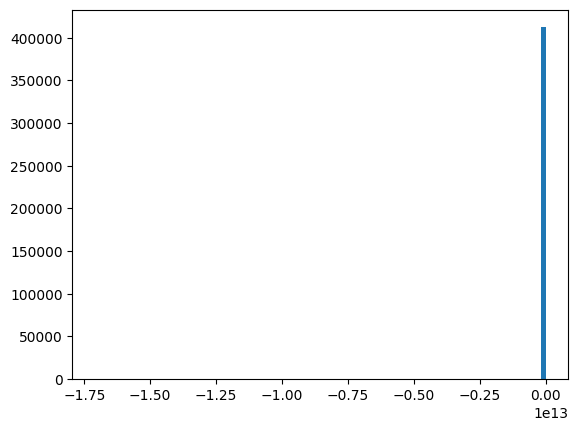

In [48]:

plt.hist(feature_df.nu20, bins=100)


In [253]:
feature_df.columns[-5:-1]

Index(['nu20', 'nu11', 'nu02', 'elongation'], dtype='object')

In [269]:
ai = np.where((principal_components[:, 0] > -0.003) & (principal_components[:, 0] < -0.002) & (principal_components[:, 1] > -0.25) & (principal_components[:, 1] < -0.15))
fi = feature_df.iloc[ai]
ff = df.loc[fi.id]
ff.loc[(ff.vel > 0.6) & (ff.lh > 7) & (ff.lh < 20), ['id', 'lh', 'elongation']]

,id,lh,elongation
45496,45496,15.077230,1.039912
72017,72017,11.632134,1.061951
88080,88080,16.596344,1.009668
88713,88713,16.488276,1.015160
91761,91761,16.594301,1.063839
...,...,...,...
642266,642266,7.062758,0.951825
642700,642700,8.488729,1.051477
642792,642792,7.340051,1.018913
643380,643380,7.200455,1.050699


In [49]:
plot_result(1)

NameError: name 'plot_result' is not defined

In [273]:
df.dropna()

,id,x,y,lh,vx,vy,vel,ang,jpl_id,jpl_x,...,mu03,nu20,nu11,nu02,nu30,nu21,nu12,nu03,elongation,neg
525,525,4542,4442,264.636536,0.466948,-0.480478,0.67,-0.799678,1998 UW1,4541.263220,...,1.687134e+06,0.000023,3.820971e-06,0.000026,-5.511342e-09,-9.638744e-09,-2.795873e-09,4.430852e-08,1.186646,36
812,812,2370,3290,224.574829,0.628179,-0.308855,0.70,-0.456959,1991 GN10,2369.506827,...,1.729008e+06,-0.000053,-3.865132e-07,-0.000050,5.485442e-07,1.420404e-07,1.686846e-07,3.391042e-07,0.974023,317
3505,3505,3930,1583,124.115807,0.490000,0.000000,0.49,0.000000,1976 YX1,3930.440169,...,-8.745843e+05,-0.000346,-1.584521e-05,-0.000290,-7.520930e-06,3.268065e-07,-3.444635e-06,-2.563733e-06,0.902639,297
6357,6357,2802,1899,93.226921,0.580000,0.000000,0.58,0.000000,1998 QH11,2801.755383,...,-4.390081e+05,0.000203,-3.071257e-05,0.000197,-5.641827e-07,-2.941432e-07,7.306965e-08,-3.573139e-07,1.168258,24
6557,6557,4638,3208,96.053200,0.580000,0.000000,0.58,0.000000,1999 AT21,4637.612871,...,3.952470e+05,0.000151,-6.065100e-05,0.000153,-1.498304e-06,-7.242411e-08,-1.018269e-07,6.095047e-07,1.526832,126
8295,8295,4896,2908,86.235428,0.594147,0.138163,0.61,0.228479,1999 YR4,4896.228638,...,8.700772e+05,-0.000197,-6.794022e-05,-0.000092,-7.554812e-06,3.593013e-06,2.646129e-07,3.054060e-06,0.503327,218
12616,12616,4379,1986,70.751144,0.457002,-0.052436,0.46,-0.114240,2000 AT131,4378.812346,...,-1.000023e+06,0.000332,-3.276306e-06,0.000354,-7.824105e-07,-6.409623e-07,-2.224420e-06,-1.688806e-06,1.035019,63
15719,15719,2528,2520,61.779503,0.580000,0.000000,0.58,0.000000,1998 BS23,2527.928171,...,1.458570e+06,-0.002536,-4.671486e-07,-0.002876,5.563061e-07,1.269508e-05,1.009329e-05,6.512843e-05,0.939027,296
21674,21674,2484,1922,49.993786,0.670000,0.000000,0.67,0.000000,1993 FT52,2484.443589,...,-6.912897e+05,0.000357,-1.509998e-05,0.000357,-1.269119e-06,-3.643839e-07,-9.749432e-07,-1.090200e-06,1.043199,11
24858,24858,1958,4593,46.865929,0.588878,-0.378448,0.70,-0.571198,2000 AW185,1958.001092,...,-9.829513e+05,0.000360,-2.483262e-05,0.000360,-1.822381e-06,-3.147151e-07,-4.919281e-07,-1.146257e-06,1.071528,13


Finding positions of trajectory lh: 9.168424 flux: 209.434647 x: 5132 y: 4449 x_v: 356.129028 y_v: 0.000000 obs_count: 14
0.459999994913737 270.0


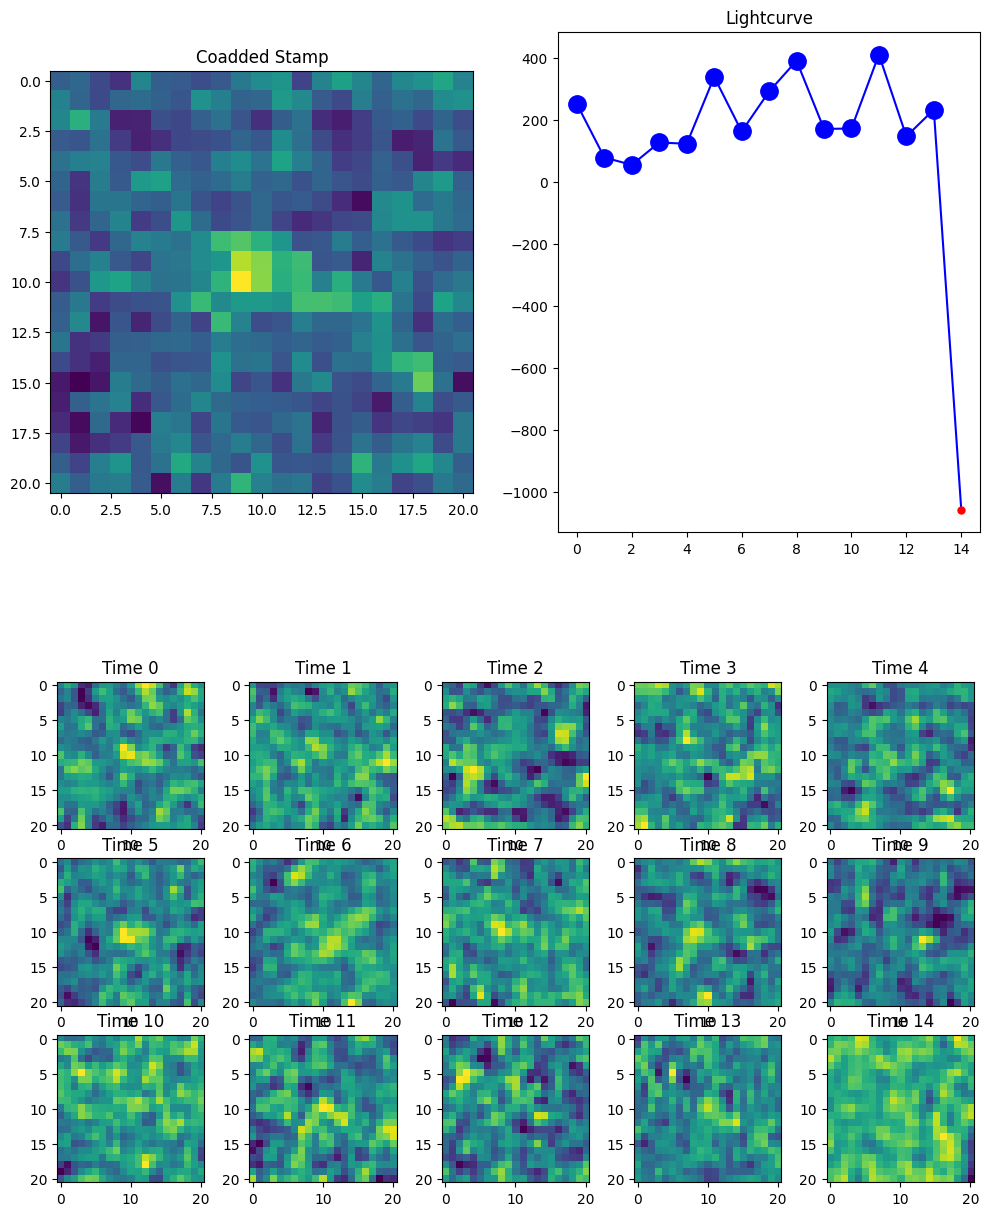

In [276]:
plot_result(436406)

In [144]:
# t-sne
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(norm_feature_array)

KeyboardInterrupt: 

In [151]:
df.columns

Index(['id', 'x', 'y', 'lh', 'vx', 'vy', 'vel', 'ang', 'jpl_id', 'jpl_x',
       'jpl_y', 'jpl_ra', 'jpl_dec', 'jpl_mag', 'jpl_rate_ra', 'jpl_rate_dec',
       'jpl_rate', 'jpl_pa', 'jpl_sep', 'm00', 'm10', 'm01', 'm20', 'm11',
       'm02', 'm30', 'm21', 'm12', 'm03', 'mu20', 'mu11', 'mu02', 'mu30',
       'mu21', 'mu12', 'mu03', 'nu20', 'nu11', 'nu02', 'nu30', 'nu21', 'nu12',
       'nu03', 'elongation', 'neg'],
      dtype='object')

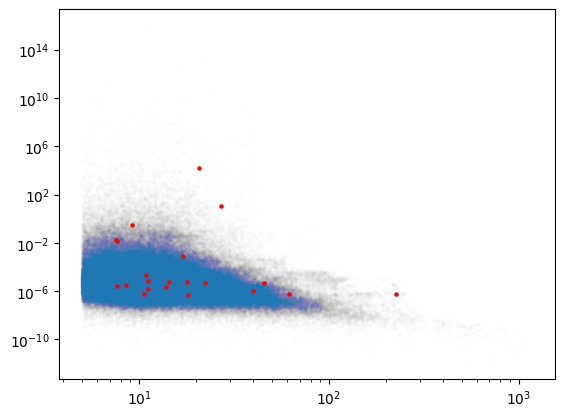

In [176]:
feature_name = 'm10'
# plot scatter 

# plt.scatter(df.lh, np.abs(df['nu20'] - df['nu02']), s=5, alpha=.002)
# plt.scatter(df.dropna().lh, np.abs(df.dropna()['nu20'] - df.dropna()['nu02']), s=5, c='r')
plt.scatter(df.lh, df['nu30'], s=5, alpha=.002)
plt.scatter(df.dropna().lh, df.dropna()['nu30'], s=5, c='r')

plt.xscale('log')
plt.yscale('log')

In [175]:
df.dropna()

,id,x,y,lh,vx,vy,vel,ang,jpl_id,jpl_x,...,mu03,nu20,nu11,nu02,nu30,nu21,nu12,nu03,elongation,neg
525,525,4542,4442,264.636536,0.466948,-0.480478,0.67,-0.799678,1998 UW1,4541.263220,...,1.687134e+06,0.000023,3.820971e-06,0.000026,-5.511342e-09,-9.638744e-09,-2.795873e-09,4.430852e-08,1.186646,36
812,812,2370,3290,224.574829,0.628179,-0.308855,0.70,-0.456959,1991 GN10,2369.506827,...,1.729008e+06,-0.000053,-3.865132e-07,-0.000050,5.485442e-07,1.420404e-07,1.686846e-07,3.391042e-07,0.974023,317
3505,3505,3930,1583,124.115807,0.490000,0.000000,0.49,0.000000,1976 YX1,3930.440169,...,-8.745843e+05,-0.000346,-1.584521e-05,-0.000290,-7.520930e-06,3.268065e-07,-3.444635e-06,-2.563733e-06,0.902639,297
6357,6357,2802,1899,93.226921,0.580000,0.000000,0.58,0.000000,1998 QH11,2801.755383,...,-4.390081e+05,0.000203,-3.071257e-05,0.000197,-5.641827e-07,-2.941432e-07,7.306965e-08,-3.573139e-07,1.168258,24
6557,6557,4638,3208,96.053200,0.580000,0.000000,0.58,0.000000,1999 AT21,4637.612871,...,3.952470e+05,0.000151,-6.065100e-05,0.000153,-1.498304e-06,-7.242411e-08,-1.018269e-07,6.095047e-07,1.526832,126
8295,8295,4896,2908,86.235428,0.594147,0.138163,0.61,0.228479,1999 YR4,4896.228638,...,8.700772e+05,-0.000197,-6.794022e-05,-0.000092,-7.554812e-06,3.593013e-06,2.646129e-07,3.054060e-06,0.503327,218
12616,12616,4379,1986,70.751144,0.457002,-0.052436,0.46,-0.114240,2000 AT131,4378.812346,...,-1.000023e+06,0.000332,-3.276306e-06,0.000354,-7.824105e-07,-6.409623e-07,-2.224420e-06,-1.688806e-06,1.035019,63
15719,15719,2528,2520,61.779503,0.580000,0.000000,0.58,0.000000,1998 BS23,2527.928171,...,1.458570e+06,-0.002536,-4.671486e-07,-0.002876,5.563061e-07,1.269508e-05,1.009329e-05,6.512843e-05,0.939027,296
21674,21674,2484,1922,49.993786,0.670000,0.000000,0.67,0.000000,1993 FT52,2484.443589,...,-6.912897e+05,0.000357,-1.509998e-05,0.000357,-1.269119e-06,-3.643839e-07,-9.749432e-07,-1.090200e-06,1.043199,11
24858,24858,1958,4593,46.865929,0.588878,-0.378448,0.70,-0.571198,2000 AW185,1958.001092,...,-9.829513e+05,0.000360,-2.483262e-05,0.000360,-1.822381e-06,-3.147151e-07,-4.919281e-07,-1.146257e-06,1.071528,13


In [154]:
df['nu20'] - df['nu02']

0         7.149573e-07
1        -9.603983e-07
2         9.090933e-07
3        -1.292881e-06
4         1.611248e-06
              ...     
648094   -2.164795e-05
648095   -1.612281e-04
648096    4.995320e-04
648097    3.568315e-05
648098   -3.358202e-04
Length: 648099, dtype: float64

In [149]:
feature_df.dropna()

,id,lh,m00,m10,m01,m20,m11,m02,m30,m21,m12,m03,mu20,mu11,mu02,nu20,nu11,nu02,elongation,neg
0,0,960.739807,5.184745e+06,5.266976e+07,5.166699e+07,5.735078e+08,5.311736e+08,5.341093e+08,6.623617e+09,5.847410e+09,5.553201e+09,5.706817e+09,3.845681e+07,6.309286e+06,1.923762e+07,1.430600e-06,2.347066e-07,7.156432e-07,1.524808,28
1,1,960.411865,5.183977e+06,5.042691e+07,5.329040e+07,5.081914e+08,5.109116e+08,5.912914e+08,5.289340e+09,5.076603e+09,5.604472e+09,6.952049e+09,1.766581e+07,-7.468437e+06,4.347519e+07,6.573662e-07,-2.779096e-07,1.617765e-06,1.704159,35
2,2,1184.040894,3.431228e+06,3.341067e+07,3.443266e+07,3.508687e+08,3.420905e+08,3.603728e+08,3.903075e+09,3.646870e+09,3.641427e+09,3.914793e+09,2.554120e+07,6.811603e+06,1.483815e+07,2.169413e-06,5.785623e-07,1.260319e-06,1.582066,39
3,3,1083.207764,3.431194e+06,3.432162e+07,3.529671e+07,3.558304e+08,3.563635e+08,3.908362e+08,3.810012e+09,3.725262e+09,3.973061e+09,4.577958e+09,1.251745e+07,3.296861e+06,2.773866e+07,1.063225e-06,2.800336e-07,2.356106e-06,1.549748,36
4,4,1074.428467,2.848897e+06,2.896705e+07,2.863677e+07,3.185819e+08,2.939476e+08,2.988264e+08,3.717639e+09,3.255353e+09,3.092513e+09,3.223675e+09,2.405038e+07,2.774370e+06,1.097315e+07,2.963252e-06,3.418306e-07,1.352004e-06,1.537780,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
648093,648093,5.000115,2.292537e+03,5.346385e+04,2.115956e+04,2.544715e+05,6.419576e+05,-5.742618e+05,-4.004786e+06,5.138056e+06,-4.358209e+05,-2.276665e+07,-9.923497e+05,1.484992e+05,-7.695595e+05,-1.888131e-01,2.825475e-02,-1.464231e-01,0.807408,272
648094,648094,6.065104,-1.519544e+05,-1.575121e+06,-1.560295e+06,-2.363717e+07,-1.627539e+07,-2.283139e+07,-3.904222e+08,-2.424049e+08,-2.372355e+08,-3.708350e+08,-7.309867e+06,-1.017721e+05,-6.810013e+06,-3.165796e-04,-4.407600e-06,-2.949317e-04,1.038983,386
648095,648095,6.111823,9.409332e+03,1.155202e+05,8.115048e+04,1.498053e+06,1.082571e+06,7.939441e+05,2.103698e+07,1.338099e+07,1.275413e+07,8.527071e+06,7.978994e+04,8.627087e+04,9.406436e+04,9.012195e-04,9.744209e-04,1.062448e-03,21.905575,180
648096,648096,5.000032,1.097058e+04,1.083046e+05,1.232993e+05,1.334741e+06,1.168789e+06,1.591180e+06,1.896816e+07,1.444924e+07,1.473594e+07,2.294903e+07,2.655297e+05,-4.845467e+04,2.054091e+05,2.206244e-03,-4.026021e-04,1.706712e-03,1.280268,151


In [128]:
features_standardized

array([[ 3.97606300e+01,  5.31350440e+01,  5.36287491e+01, ...,
         2.07909963e-03,  1.03795375e-01, -1.16169287e+00],
       [ 3.97468215e+01,  5.31271066e+01,  5.13252953e+01, ...,
         2.07909963e-03,  2.07105706e-01, -1.10045752e+00],
       [ 4.91630470e+01,  3.50129542e+01,  3.38492052e+01, ...,
         2.07909963e-03,  1.36777286e-01, -1.06546590e+00],
       ...,
       [-4.35369619e-01, -3.50543360e-01, -3.45705667e-01, ...,
         2.07909987e-03,  1.18435815e+01,  1.67988964e-01],
       [-4.82183182e-01, -3.34408264e-01, -3.53116258e-01, ...,
         2.07910001e-03, -3.70651886e-02, -8.57003338e-02],
       [-4.82183704e-01, -7.36591452e-01, -7.03104863e-01, ...,
         2.07909918e-03, -7.71717291e-02,  1.91757033e+00]])

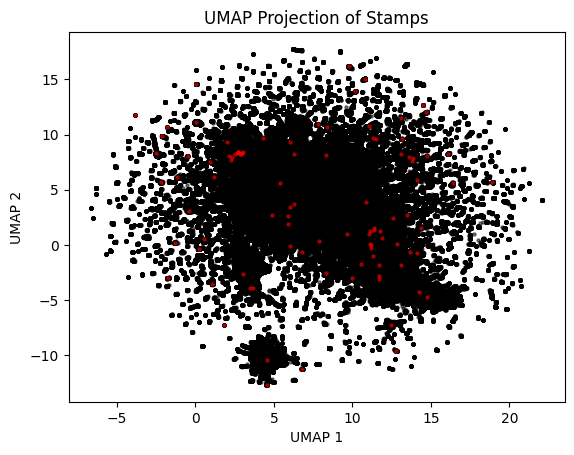

In [66]:
plt.scatter(embedding[:, 0], embedding[:, 1], s=5, color='k', alpha=0.5)

known_ast = df.dropna()
known_ast_id = known_ast.index

plt.scatter(embedding[known_ast_id, 0], embedding[known_ast_id, 1], s=5, color='r', alpha=0.5)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title('UMAP Projection of Stamps')
plt.show()


In [71]:
ids = df.index.values
ids[(embedding[:, 0] > 3) & (embedding[:, 0] < 5) & (embedding[:, 1] > -12) & (embedding[:, 1] < -8)]


array([   526,    573,    689, ..., 648047, 648058, 648094])

In [62]:
embedding.shape

(648099, 2)

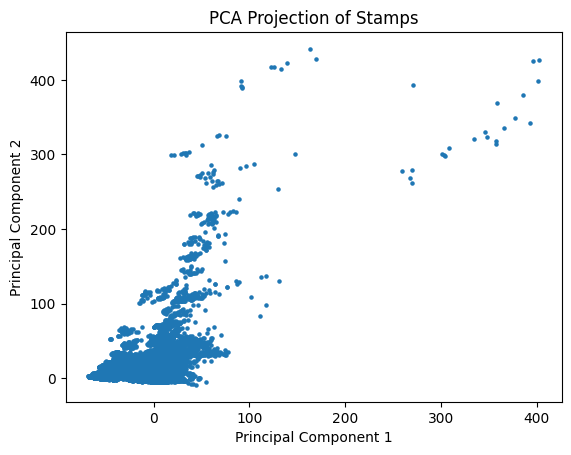

In [68]:
from sklearn.decomposition import PCA


# Flatten each 21x21 stamp into a one-dimensional array
flattened_stamps = coadded_stamp_sum.reshape(coadded_stamp_sum.shape[0], -1)

# Standardize the data
flattened_stamps_standardized = (flattened_stamps - np.mean(flattened_stamps, axis=0)) / np.std(flattened_stamps, axis=0)

# Apply PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(flattened_stamps_standardized)

# Visualize the results
plt.scatter(principal_components[:, 0], principal_components[:, 1], s=5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Projection of Stamps')
plt.show()



-- --

In [272]:
df.dropna()

,id,x,y,lh,vx,vy,vel,ang,jpl_id,jpl_x,...,mu03,nu20,nu11,nu02,nu30,nu21,nu12,nu03,elongation,neg
525,525,4542,4442,264.636536,0.466948,-0.480478,0.67,-0.799678,1998 UW1,4541.263220,...,1.687134e+06,0.000023,3.820971e-06,0.000026,-5.511342e-09,-9.638744e-09,-2.795873e-09,4.430852e-08,1.186646,36
812,812,2370,3290,224.574829,0.628179,-0.308855,0.70,-0.456959,1991 GN10,2369.506827,...,1.729008e+06,-0.000053,-3.865132e-07,-0.000050,5.485442e-07,1.420404e-07,1.686846e-07,3.391042e-07,0.974023,317
3505,3505,3930,1583,124.115807,0.490000,0.000000,0.49,0.000000,1976 YX1,3930.440169,...,-8.745843e+05,-0.000346,-1.584521e-05,-0.000290,-7.520930e-06,3.268065e-07,-3.444635e-06,-2.563733e-06,0.902639,297
6357,6357,2802,1899,93.226921,0.580000,0.000000,0.58,0.000000,1998 QH11,2801.755383,...,-4.390081e+05,0.000203,-3.071257e-05,0.000197,-5.641827e-07,-2.941432e-07,7.306965e-08,-3.573139e-07,1.168258,24
6557,6557,4638,3208,96.053200,0.580000,0.000000,0.58,0.000000,1999 AT21,4637.612871,...,3.952470e+05,0.000151,-6.065100e-05,0.000153,-1.498304e-06,-7.242411e-08,-1.018269e-07,6.095047e-07,1.526832,126
8295,8295,4896,2908,86.235428,0.594147,0.138163,0.61,0.228479,1999 YR4,4896.228638,...,8.700772e+05,-0.000197,-6.794022e-05,-0.000092,-7.554812e-06,3.593013e-06,2.646129e-07,3.054060e-06,0.503327,218
12616,12616,4379,1986,70.751144,0.457002,-0.052436,0.46,-0.114240,2000 AT131,4378.812346,...,-1.000023e+06,0.000332,-3.276306e-06,0.000354,-7.824105e-07,-6.409623e-07,-2.224420e-06,-1.688806e-06,1.035019,63
15719,15719,2528,2520,61.779503,0.580000,0.000000,0.58,0.000000,1998 BS23,2527.928171,...,1.458570e+06,-0.002536,-4.671486e-07,-0.002876,5.563061e-07,1.269508e-05,1.009329e-05,6.512843e-05,0.939027,296
21674,21674,2484,1922,49.993786,0.670000,0.000000,0.67,0.000000,1993 FT52,2484.443589,...,-6.912897e+05,0.000357,-1.509998e-05,0.000357,-1.269119e-06,-3.643839e-07,-9.749432e-07,-1.090200e-06,1.043199,11
24858,24858,1958,4593,46.865929,0.588878,-0.378448,0.70,-0.571198,2000 AW185,1958.001092,...,-9.829513e+05,0.000360,-2.483262e-05,0.000360,-1.822381e-06,-3.147151e-07,-4.919281e-07,-1.146257e-06,1.071528,13


In [ ]:
min_dist = 20
df_dist = df_ast.loc[(df_ast.sep < min_dist) & (np.abs(df_ast.jpl_rate - df_ast.vel) < df_ast.jpl_rate*0.5)]
bins = np.linspace(df_ast.jpl_MAG.min(), df_ast.jpl_MAG.max(), 20)

plt.figure(figsize=(6,5))
plt.hist(df_ast.jpl_MAG, bins=bins, alpha=0.5, label='All asteroids (%i)' % len(df_ast), color='k')
plt.hist(df_dist.jpl_MAG, bins=bins, alpha=0.5, label='Detected (%i/%i)' % (len(df_dist), results.num_results()), color='b')
plt.xlabel('mag')
plt.ylabel('count')
plt.legend()
plt.show()


In [ ]:
df_cross = df.dropna()
df_cross = df_cross.loc[(np.abs(df_cross.jpl_rate - df_cross.vel) < df_cross.jpl_rate*0.2)]
df_cross.sort_values(by='jpl_mag')

In [ ]:

ast = asteroid.assign(key=1)
trans = df.assign(key=1)
cross_join = ast.merge(trans, on='key').drop('key', axis=1)
cross_join['distance'] = ((cross_join['jpl_x'] - cross_join['x']) ** 2 + (cross_join['jpl_y'] - cross_join['y']) ** 2) ** 0.5 * 3600


In [ ]:
crossed = find_known_asteroids(df, asteroid, limit=10)


In [ ]:
crossed.sort_values(by='jpl_MAG')

In [ ]:
from matplotlib import pyplot as plt
plt.imshow(d[1,-1100:,-1100:], vmin=150, vmax=200, cmap='gray')
plt.colorbar()
plt.show()

In [ ]:
WCS(fits.getheader(res))

In [ ]:
stack, img_info = ATLAS_Parser.load_images(sci_filelist)

In [ ]:
img_array = np.zeros((stack.img_count(), 2048, 2048))
mask_array = np.zeros((stack.img_count(), 2048, 2048))
var_array = np.zeros((stack.img_count(), 2048, 2048))
for i,ima in enumerate(stack.get_images()):
    img_array[i,:] = ima.get_science()
    mask_array[i,:] = ima.get_mask()
    var_array[i,:] = ima.get_variance()

mask = np.zeros((2048, 2048))
mask[mask_array.sum(axis=0) > 0] = 1
mask[np.max(np.abs(img_array), axis=0) > 1e4] = 0
#mask = mask.astype(bool)

In [ ]:
stack.get_images()

In [ ]:

x0, y0 = 1728, 1035 #1207, 845
size = 70
data = img_array[0, int(y0-size/2):int(y0+size/2), int(x0-size/2):int(x0+size/2)]
var = var_array[0, int(y0-size/2):int(y0+size/2), int(x0-size/2):int(x0+size/2)]
#data -= mask[int(y0-size/2):int(y0+size/2), int(x0-size/2):int(x0+size/2)]*1e5
plt.imshow(data-mask[int(y0-size/2):int(y0+size/2), int(x0-size/2):int(x0+size/2)]*1e5, cmap='gray', vmin=-50, vmax=100, origin='upper')
plt.colorbar()

In [ ]:
thres = 25
std = np.std(img_array[:, int(y0-size/2):int(y0+size/2), int(x0-size/2):int(x0+size/2)], axis=0)
std[std ==0] = 1e5
std += mask[int(y0-size/2):int(y0+size/2), int(x0-size/2):int(x0+size/2)]*1e5

plt.imshow(std, cmap='gray', vmin=5, vmax=40)
plt.colorbar()

In [ ]:
mean = np.mean(img_array[:, int(y0-size/2):int(y0+size/2), int(x0-size/2):int(x0+size/2)], axis=0)
mean -= mask[int(y0-size/2):int(y0+size/2), int(x0-size/2):int(x0+size/2)]*1e5

plt.imshow(mean, cmap='gray', vmin=-5, vmax=10)
plt.colorbar()

In [ ]:
3/np.sqrt(2)

In [ ]:
# plot scatter data vs std in color log scale

x= np.abs(data[std < 1e3])
y = std[std < 1e3]

plt.scatter(x, y, c=np.log10(y), cmap='viridis', s=10, alpha=0.5)



In [ ]:
plt.imshow(np.sqrt(var), cmap='gray')#, vmin=0, vmax=5)
plt.colorbar()

In [ ]:
n = stack.img_count()
#std = np.std(img_array[:, int(y0-size/2):int(y0+size/2), int(x0-size/2):int(x0+size/2)], axis=0)
#std[std ==0] = 1e5
#std += mask[int(y0-size/2):int(y0+size/2), int(x0-size/2):int(x0+size/2)]*1e5

thres = (n / np.sqrt(n-1))
mm = np.abs(data)/std

plt.imshow(mm, cmap='gray', vmin=0, vmax=0.75*thres)
plt.colorbar()

In [ ]:
mm

In [ ]:
bck_mask = np.abs(data) < np.sqrt(var)

bck = np.median(data[bck_mask])
bck_sigma = np.std(data[bck_mask])

P = 5
n = stack.img_count()

res_mask = (mm<P*thres) & (np.abs(data)>3*bck_sigma)

print(np.prod(data.shape), np.sum(res_mask))

In [ ]:
bck_sigma  

In [ ]:
res_mask = (data > -np.sqrt(var)) & (data < np.sqrt(var))
res_mask = (np.abs(data)/std < 1+(thres-1)*0.5) & (np.abs(data)>5*bck_sigma)

In [ ]:
# plot data and mask

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

g = ax[0].imshow(data, cmap='gray', vmin=-50, vmax=100)
# add colorbar
plt.colorbar(g, fraction=0.046, pad=0.04)

ax[1].imshow(res_mask, cmap='gray', vmin=0, vmax=1)

In [ ]:
P*n/np.sqrt(n-1)

In [ ]:
DIFF = np.zeros((len(sci_filelist), 2048, 2048))
for i,file in enumerate(sci_filelist):
    img, header, mask, var, diff = ATLAS_Parser.get_image(file)
    DIFF[i,:] = diff

In [ ]:
AstrometryNet().api_key

In [ ]:
with fits.open(im, output_verify='silentfix') as hdul:
    img = hdul[1].data
    mask = hdul[2].data

In [ ]:
sci_filelist


In [ ]:
st_ori, img_info = rs.Parser.load_images(sci_filelist, save=True)

In [ ]:
type(st_ori)


In [ ]:
from copy import deepcopy

In [ ]:
2.65/2.355

In [ ]:
stack = st_ori
im = stack.get_images()[-1]
a = im.get_science()
x_center, y_center = 473, 782
area = 50
plt.imshow(a, cmap="gray", vmin=-10, vmax=100)
plt.title("Original Image")
plt.xlim(x_center-area/2, x_center+area/2)
plt.ylim(y_center-area/2, y_center+area/2)
plt.colorbar()

In [ ]:
print(np.median(a.get_all_pixels()), np.std(a.get_all_pixels()))
print(np.median(b.get_all_pixels()), np.std(b.get_all_pixels()))

In [ ]:
# im = st_ori.get_images()[1]
psf = im.get_psf().get_stdev()
print(psf)
im.set_psf(kb.psf(psf))
a = im.generate_psi_image()
b = im.generate_phi_image()

fig, ax = plt.subplots(1,3, figsize=(12,4))
ax[0].imshow(a, cmap='gray', vmin=-.1, vmax=.1)
ax[1].imshow(b, cmap='gray', vmin=0.00037, vmax=0.00041)
ax[2].imshow(a/np.sqrt(b), cmap='gray', vmin=-1, vmax=4,)
labs = [r'$\psi$', r'$\phi$', r'$\psi/\sqrt{\phi}$']


for i in range(3):
    ax[i].set_xlim([x_center-area/2, x_center+area/2])
    ax[i].set_ylim([y_center-area/2, y_center+area/2])
    ax[i].set_title(labs[i])


In [ ]:
fig, ax = plt.subplots(3,2, figsize=(10,15))
psf_array = [0.5, 1.07, 1.5, 2, 3, 4]

for i,psf in enumerate(psf_array):
    im = st_ori.get_images()[0]
    im.set_psf(kb.psf(psf))
    a = im.generate_psi_image()
    b = im.generate_phi_image()
    img = ax[i//2, i%2].imshow(a/np.sqrt(b), cmap="gray", vmin=-1, vmax=4)
    ax[i//2, i%2].set_title(r'PSF$_{std}$='+str(psf))
    ax[i//2, i%2].set_xlim([x_center-area/2, x_center+area/2])
    ax[i//2, i%2].set_ylim([y_center-area/2, y_center+area/2])


fig.tight_layout()

In [ ]:
psf_kernel = np.array([[0.00042652, 0.00052738, 0.00097838, 0.00112309, 0.00158336,
         0.0016751 , 0.00140083, 0.0007724 , 0.00079965],
        [0.00021876, 0.00107289, 0.00220688, 0.00450126, 0.00553412,
         0.00488591, 0.0031191 , 0.00112619, 0.00048173],
        [0.0008282 , 0.00236398, 0.00779977, 0.01766621, 0.02240861,
         0.01803395, 0.0081634 , 0.00253804, 0.00093612],
        [0.00097769, 0.0043783 , 0.01982922, 0.06072872, 0.07278261,
         0.04563654, 0.01622331, 0.00382515, 0.0012349 ],
        [0.00096178, 0.00488396, 0.02338596, 0.07814466, 0.11070463,
         0.0735097 , 0.02405481, 0.00546485, 0.00152598],
        [0.0009763 , 0.00301376, 0.01390835, 0.04314648, 0.07351017,
         0.05821257, 0.02069398, 0.00546595, 0.00105739],
        [0.00058731, 0.00166617, 0.00604943, 0.01540031, 0.02433023,
         0.0218684 , 0.01046884, 0.0031474 , 0.00102326],
        [0.00024802, 0.00095716, 0.00208563, 0.00420922, 0.00642536,
         0.00621934, 0.00338536, 0.00124712, 0.00053333],
        [0.00048246, 0.00040518, 0.00094373, 0.00144277, 0.00208587,
         0.00134638, 0.00115899, 0.00046526, 0.00040786]])

In [ ]:
psf_kernel.shape

In [ ]:
with fits.open(im, output_verify='silentfix') as hdul:
    img = hdul[1].data
    mask = hdul[2].data

In [ ]:
psf_kernel.shape

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10,7))
im = st_ori.get_images()[0]

# 2d gaussian filter
a = im.generate_psi_image()
b = im.generate_phi_image()
img = ax[0].imshow(a/np.sqrt(b), cmap="gray", vmin=0, vmax=4)
ax[0].set_title(r'Gaussian PSF')
ax[0].set_xlim([x_center-area/2, x_center+area/2])
ax[0].set_ylim([y_center-area/2, y_center+area/2])

# numeric psf
im.set_psf(kb.psf(psf_kernel))
a = im.generate_psi_image()
b = im.generate_phi_image()
img = ax[1].imshow(a/np.sqrt(b), cmap="gray", vmin=0, vmax=4)
ax[1].set_title(r'Numeric PSF')
ax[1].set_xlim([x_center-area/2, x_center+area/2])
ax[1].set_ylim([y_center-area/2, y_center+area/2])


fig.tight_layout()


In [ ]:
sci, header, mask, var, diff = ATLAS_Parser.get_image(sci_filelist[0])

In [ ]:
mask

In [ ]:
stack, img_info = ATLAS_Parser.load_images(sci_filelist, save=True)

In [ ]:
center_pixel = (img_info.stats[0].width / 2, img_info.stats[0].height / 2)
(img_info.stats[0].wcs, center_pixel)

In [ ]:
header

In [ ]:
ATLAS_Parser.arcsecmin_to_pxday(0.58)

In [ ]:
trj0 = row0.trajectory
sky_pos = ATLAS_Parser.img_info.trajectory_to_skycoords(trj0)
for i, pos in enumerate(sky_pos):
    print(f"{i}: ({pos.ra.degree}, {pos.dec.degree})")
    ra_str = pos.ra.to_string(unit=u.hourangle, sep=':', pad=True, precision=2)
    dec_str = pos.dec.to_string(unit=u.degree, sep=':', alwayssign=True, pad=True, precision=1)
    print(f"{i}: ({ra_str}, {dec_str})")

In [ ]:
trj0 = row0.trajectory
print(f"Finding positions of trajectory {trj0}")

slice = 200
d = np.zeros((trj0.obs_count, 2*slice, 2*slice))
for i,image in enumerate(sci_filelist):
    data = fits.getdata(image, 1)
    d[i,:] = data[trj0.x-slice:trj0.x+slice, trj0.y-slice:trj0.y+slice]



In [ ]:
import matplotlib.pyplot as plt
import numpy as np
try: import imageio
except:
    !pip install imageio
    import imageio
from IPython.display import Image, display
try: import cv2
except:
    !pip install opencv-python
    import cv2

# Normalize images for better contrast
min_val = np.median(d[0]) - 2*np.std(d[0])
max_val = np.median(d[0]) + 2*np.std(d[0])
d = (d - min_val) / (max_val - min_val)

# Create a figure and an axis in matplotlib
fig, ax = plt.subplots()
images = []

for i in range(d.shape[0]):
    im = ax.imshow(d[i], animated=True, cmap='gray')
    plt.axis('off')
    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    images.append(image)
plt.close()

#images_resized = [cv2.resize(img, (400, 400)) for img in images]
imageio.mimsave('animation.gif', images)
with open('animation.gif','rb') as f:
    display(Image(data=f.read(), format='png'))


In [ ]:
stack.get_images()[0].get_header()

In [ ]:
if os.path.exists(ATLAS_Parser.kbmod_image_path):
    if os.path.exists(os.path.join(ATLAS_Parser.kbmod_image_path, "out/")) is False:
        os.mkdir(os.path.join(ATLAS_Parser.kbmod_image_path, "out/"))


    search.save_psi_phi(os.path.join(ATLAS_Parser.kbmod_image_path, "out"))
else:
    print("Data directory does not exist. Skipping file operations.")

In [ ]:
fits.info(os.path.join(ATLAS_Parser.kbmod_image_path, os.path.basename(sci_filelist[0]).replace('fits.fz','layered.fits')))

In [ ]:
filename = sci_filelist[0]

filename.rsplit("/")[-1].split(".")[0]

In [ ]:
file_path = sci_filelist[0]
diff = ATLAS_Parser.uncompress_atlas_data(file_path.replace('.fits.fz', '.diff.fz'), type='diff')[0]
sci, mask, var = ATLAS_Parser.uncompress_atlas_data(file_path, type='science')

layered = [diff, mask, var]
HDU = fits.HDUList(layered)

In [ ]:
sci

In [ ]:
# load atlas image
img_path = sci_filelist[0]
header = fits.getheader(img_path,1)

image_info = ImageInfo()
image_info.populate_from_fits_file(img_path)

image_info.set_epoch(Time(header['MJD-OBS'], format="mjd", scale="utc"))
image_info.set_obs_code(header['OBSERVAT'])
image_info.set_obs_position(header['OBS-LONG'], header['OBS-LAT'], header['OBS-ELEV'])
image_info.set_layered_image(fits.getdata(img_path,1))

In [ ]:
fits.i
info('/app/data/demo/000000.fits')
    

In [ ]:
fits.getheader('/app/data/demo/000000.fits',2)


im = kb.layered_image('/app/data/demo/000000.fits', kb.psf(1.5))

In [ ]:
im.get_time()

In [ ]:
header['MJD-OBS']

-- --
CHECK RESIDUALS
-- --

In [ ]:
from astroquery.vizier import Vizier
import numpy as np
import pandas as pd
from astropy import units as u
from astropy.coordinates import SkyCoord, angles

from astropy import units as u

def __getVizierALL(catalog):
    Vizier.ROW_LIMIT = -1
    results = Vizier.get_catalogs([catalog])
    table = results[0]
    return table


def __getVizier(catalog,radec,radii,maglimit):

    # Gaia catalog I/345/gaia2 columns=['RA_ICRS', 'DE_ICRS', 'Gmag', 'e_Gmag']
    # vizier_results = Vizier(timeout=60, columns=['RA2000', 'DE2000', 'Vmag']).query_region(star, radius=1500*u.arcsec, catalog='V/53A/catalog', column_filters={'Vmag': '<7'})
    Vizier.ROW_LIMIT = -1
    timeout = 60
    if catalog == 'I/345/gaia2':
        vizier_results = Vizier(timeout=timeout, columns=['DR2Name','RA_ICRS', 'DE_ICRS', 'Gmag', 'e_Gmag', 'BP-G'],row_limit=-1)\
        .query_region(radec, radius=radii*u.arcsec, catalog=catalog, column_filters={'Gmag': '<'+str(maglimit),'Gmag': '!= '+'','BP-G': '!= '+''},cache=True)
        

        
    if catalog == 'II/349/ps1':
        vizier_results = Vizier(timeout=timeout, columns=['objID', 'RAJ2000', 'DEJ2000','e_RAJ2000', 'e_DEJ2000','gmag', 'e_gmag', 'rmag', 'e_rmag','imag','e_imag','zmag','e_zmag'],row_limit=-1)\
        .query_region(radec, radius=radii*u.arcsec, catalog=catalog, column_filters={'gmag': '<'+str(maglimit),'rmag': '!= '+'','gmag': '!= '+'','imag': '!= '+'','zmag': '!= '+''},cache=True)
    if catalog == 'II/183A/table2':
        vizier_results = Vizier(timeout=timeout, columns=['objID','RAJ2000', 'DEJ2000','Vmag', 'e_Vmag', 'B-V', 'V-R','R-I'],row_limit=-1)\
        .query_region(radec, radius=radii*u.deg, catalog=catalog, column_filters={'Vmag': '<'+str(maglimit),'B-V': '!= '+'','V-R': '!= '+'','R-I': '!= '+''},cache=True)
    return vizier_results[0]

def catalog_results(coocenter, FOV, filter, maglimit=23):
    labels={}
    radii_int=int(np.sqrt(FOV)*1800) # internal radius
    radii_ext=int(np.sqrt(2)*radii_int)  # external radius
    radii=radii_ext
    if filter=='Open' or filter=='OPEN' or filter == 'Lum' or filter == 'w':
        catalog='I/345/gaia2' # GAIA catalog
        vizier_results=__getVizier(catalog,coocenter,radii,maglimit)
        vizier_results.rename_column('RA_ICRS', 'RA');vizier_results.rename_column('DE_ICRS', 'DEC')
        vizier_results.rename_column('BP-G', 'color')
        vizier_results.rename_column('Gmag', 'rmag')
        vizier_results.rename_column('DR2Name', 'objID')
        mask_solar = (vizier_results['color'] < 0.9) & (vizier_results['color'] > 0.2) # solar like stars
               
             
    else:
        catalog='II/349/ps1' # PANSTAR catalog
        vizier_results=__getVizier(catalog,coocenter,radii,maglimit)
        vizier_results.rename_column('RAJ2000', 'RA');vizier_results.rename_column('DEJ2000', 'DEC')
        vizier_results['color']=vizier_results['gmag'] - vizier_results['rmag']
        vizier_results['color1']=vizier_results['rmag'] - vizier_results['imag']
        vizier_results['color2']=vizier_results['imag'] - vizier_results['zmag']
        mask_solar = (vizier_results['color'] < 0.64) & (vizier_results['color'] > 0.24)
        
        # BVRI transformations from Jordi et al. (2005)
        # http://www.sdss3.org/dr8/algorithms/sdssUBVRITransform.php#Jordi2006
        # B-g   =     (0.313 ± 0.003)*(g-r)  + (0.219 ± 0.002)
        # V-g   =     (-0.565 ± 0.001)*(g-r) - (0.016 ± 0.001)
        # R-r   =     (-0.153 ± 0.003)*(r-i) - (0.117 ± 0.003)
        # I-i   =     (-0.386 ± 0.004)*(i-z) - (0.397 ± 0.001)
        if filter=='U' or filter=='B' or filter=='V' or filter=='R' or filter=='I':
            vizier_results['B']=vizier_results['gmag']+0.313*vizier_results['color']+0.219
            vizier_results['V']=vizier_results['gmag']-0.565*vizier_results['color']-0.016
            vizier_results['R']=vizier_results['rmag']-0.153*vizier_results['color1']-0.117
            vizier_results['I']=vizier_results['imag']-0.386*vizier_results['color2']-0.397
            vizier_results['color3']=vizier_results['B'] - vizier_results['V']
            vizier_results['color4']=vizier_results['V'] - vizier_results['R']
            vizier_results['color5']=vizier_results['R'] - vizier_results['I']
    print('Input parameters for standard catalog search: FOV={:.2f}'.format(FOV), '(degrees**2), radius(int/ext/user defined)=',radii_int,radii_ext,radii,' (arcsec)')
    print('Total '+catalog+' catalog stars found',len(vizier_results),' for '+filter+' magnitud < {:.2f}'.format(maglimit))
        #mag_P10=np.percentile(vizier_results[filter],10);mag_P50=np.percentile(vizier_results[filter],50);mag_P70=np.percentile(vizier_results[filter],70);mag_P99=np.percentile(vizier_results[filter],99)
        #print('STATS P10={:.2f},P50={:.2f}, P70={:.2f}, P99={:.2f}'.format(mag_P10,mag_P50,mag_P70,mag_P99))
    vizier_results['mask_solar'] = mask_solar
    return vizier_results,catalog,labels


In [ ]:
glob(ATLAS_Parser.kbmod_image_path + '02a60147*.fits')

In [ ]:
#ATLAS_Parser = ATLASParser(working_path, image_type=img_typ, crop_params=None)
#img, header, mask, var, diff = ATLAS_Parser.get_image(sci_filelist[0])

from astropy.nddata import Cutout2D
from astropy.wcs import WCS
from astropy import units as u
from astropy.coordinates import SkyCoord

img = fits.getdata(sci_filelist[0], 1)
header = fits.getheader(sci_filelist[0].replace('.fits', '.diff'), 1)
# header['CTYPE'] = 'RA---TAN-SIP'
# header['CTYPE1'] = 'RA---TAN-SIP'
# header['CTYPE2'] = 'DEC--TAN-SIP'
wcs = WCS(head)


# cutout2d
center = SkyCoord(head['RA'], head['DEC'], unit=u.deg, frame='icrs')  # ra, dec in degrees
size = (2000, 2000)

# Create the cutout
cutout = Cutout2D(img, center, size, wcs=wcs)

# Overwrite the original data with the cutout
data = cutout.data
wcs = cutout.wcs

In [ ]:
wcs.to_header()['CRVAL1']

In [ ]:
header

In [ ]:

print(wcs.wcs_world2pix([[header['CRVAL1'], header['CRVAL2']]], 1))  # this prints the center of the image in pixels

In [ ]:
print(header['CRVAL1'], header['CRVAL2'])
print(header['RA'], header['DEC'])

In [ ]:
from astropy.nddata import Cutout2D
help(Cutout2D)

In [ ]:


radec = SkyCoord(ra=wcs.to_header()['CRVAL1'], dec=wcs.to_header()['CRVAL2'], unit=(u.deg, u.deg), frame='icrs')
radii = 2*3600 #header['PIXSCALE'] * header['NAXIS1']/ 2
filter = 'V'
#res, cat, lab = catalog_results(coocenter, FOV, filter, maglimit=20)

vizier_results = Vizier(timeout=120, columns=['objID', 'RAJ2000', 'DEJ2000','e_RAJ2000', 'e_DEJ2000','gmag', 'e_gmag', 'rmag', 'e_rmag','imag','e_imag','zmag','e_zmag'],row_limit=-1)\
        .query_region(radec, radius=radii*u.arcsec, catalog='II/349/ps1', column_filters={'gmag': '<'+str(19),'rmag': '!= '+'','gmag': '!= '+'','imag': '!= '+'','zmag': '!= '+''},cache=True)

res = vizier_results[0]

In [ ]:
res

In [ ]:
x.max() - x.min()

In [ ]:
x, y = wcs.world_to_pixel_values(res['RAJ2000'], res['DEJ2000'])

In [ ]:
# plot an image crop around the furthest star 

In [ ]:
# plot the sci image and a circle around the center of each star in catalog
xmin = 0; xmax = 1000
ymin = 0; ymax = 1000
plt.figure(figsize=(10,10))
plt.imshow(sci[xmin:xmax,xmin,xmax], cmap='gray', vmin=250, vmax=400)

cropped_res = res.loc[res.]

for i in range(len(catalog)):
    plt.plot(catalog['x'][i], catalog['y'][i], 'ro', markersize=10, alpha=0.5)







In [ ]:
res['DEC'].min()

In [ ]:
help(ATLAS_Parser)

-- --
WCS tests
-- --

In [ ]:
wcs_arrays = []
for im in sci_filelist: wcs_arrays.append(WCS(ATLAS_Parser.correct_header(fits.getheader(im ,1))))

In [ ]:
# create linear trajectories
def createTraj(v: float, theta: float, t: float) -> np.array:
    T = np.array([v * np.cos(theta), v * np.sin(theta), t * v * np.cos(theta), t * v * np.sin(theta)])
    return T


def getTrajPos(self, t: np.array, i: int) -> np.array:
    time = self.stack[i].getTimes()
    return np.array([t[0] + time * t[1], t[2] + time * t[3]])

def getMultTrajPos(self, t: np.array):
    results = []
    num_times = len(self.stack)
    for i in range(num_times):
        pos = self.getTrajPos(t, i)
        results.append(pos)
    return np.array(results)

In [ ]:
%%time
wcs_arrays[0].all_world2pix(159.833333333,10.43944444444,0,quiet=True)  

In [ ]:
crop_params